In [ ]:
SAVED_MODEL_DIGIT_FILENAME = "saved_model_digit"
SAVED_MODEL_FIGURE_FILENAME = "saved_model_figure"
SAVED_MODEL_ALPHABET_FILENAME = "saved_model_alphabet"
FLOAT_TFL_MODEL_DIGIT_FILENAME = "float_model_digit.tfl"
FLOAT_TFL_MODEL_FIGURE_FILENAME = "float_model_figure.tfl"
FLOAT_TFL_MODEL_ALPHABET_FILENAME = "float_model_alphabet.tfl"
QUANTIZED_TFL_MODEL_DIGIT_FILENAME = "quantized_model_digit.tfl"
QUANTIZED_TFL_MODEL_FIGURE_FILENAME = "quantized_model_figure.tfl"
QUANTIZED_TFL_MODEL_ALPHABET_FILENAME = "quantized_model_alphabet.tfl"
TFL_CC_MODEL_DIGIT_FILENAME = "magic_wand_model_digit_data.cc"
TFL_CC_MODEL_FIGURE_FILENAME = "magic_wand_model_figure_data.cc"
TFL_CC_MODEL_ALPHABET_FILENAME = "magic_wand_model_alphabet_data.cc"

In [ ]:
!curl -L https://github.com/Jisu0917/magic_wand_all/archive/5095a5906c29f08442e12118e231eb2ac0a354e3.zip -o magic_wand_data.zip
!unzip -n magic_wand_data.zip
!rm -rf magic_wand_data_alphabets
!rm -rf magic_wand_data_digits
!rm -rf magic_wand_data_figures
!mkdir -p magic_wand_data_alphabets
!mkdir -p magic_wand_data_digits
!mkdir -p magic_wand_data_figures
!mv -f magic_wand_all-*/alphabet_* magic_wand_data_alphabets
!mv -f magic_wand_all-*/digit_* magic_wand_data_digits
!mv -f magic_wand_all-*/figure_* magic_wand_data_figures
!rm -rf magic_wand_all-*
!rm -rf magic_wand_data.zip
!rm -rf sample_data
!mkdir -p checkpoints

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  304k  100  304k    0     0   928k      0 --:--:-- --:--:-- --:--:-- 1330k
Archive:  magic_wand_data.zip
5095a5906c29f08442e12118e231eb2ac0a354e3
   creating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/alphabet_a.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/alphabet_b.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_0.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_1.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_2.json  
  inflating: magic_wand_all-5095a5906c29f08442e12118e231eb2ac0a354e3/digit_3.json  
  inflating: magic_wand_all-5095a

In [ ]:
# alphabet 데이터 스트로크 생성
import glob
import json

strokes_alphabet = []
for filename in glob.glob("magic_wand_data_alphabets/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes_alphabet.append(stroke)

In [ ]:
# digit 데이터 스트로크 생성
import glob
import json

strokes_digit = []
for filename in glob.glob("magic_wand_data_digits/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes_digit.append(stroke)

In [ ]:
# figure 데이터 스트로크 생성
import glob
import json

strokes_figure = []
for filename in glob.glob("magic_wand_data_figures/*.json"):
  with open(filename, "r") as file:
    file_contents = file.read()
  file_data = json.loads(file_contents)
  for stroke in file_data["strokes"]:
    stroke["filename"] = filename
    strokes_figure.append(stroke)

In [ ]:
import matplotlib.pyplot as plt

def plot_stroke(stroke):

  x_array = []
  y_array = []
  for coords in stroke["strokePoints"]:
    x_array.append(coords["x"])
    y_array.append(coords["y"])

  fig = plt.figure(figsize=(12.8, 4.8))
  fig.suptitle(stroke["label"])

  ax = fig.add_subplot(131)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_xlim(-0.4, 0.4)
  ax.set_ylim(-0.4, 0.4)
  ax.plot(x_array, y_array)

  plt.show()

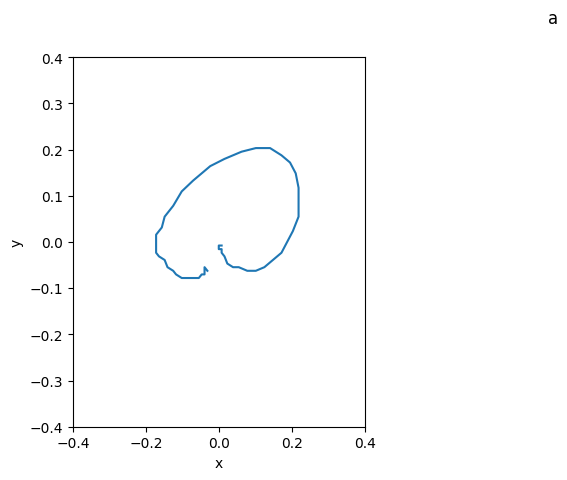

In [ ]:
plot_stroke(strokes_alphabet[11])

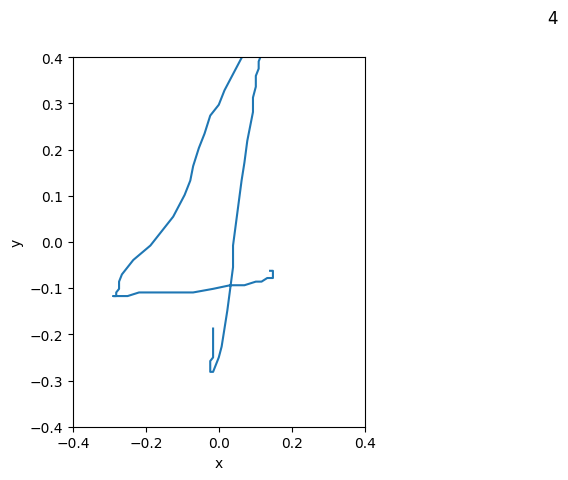

In [ ]:
plot_stroke(strokes_digit[11])

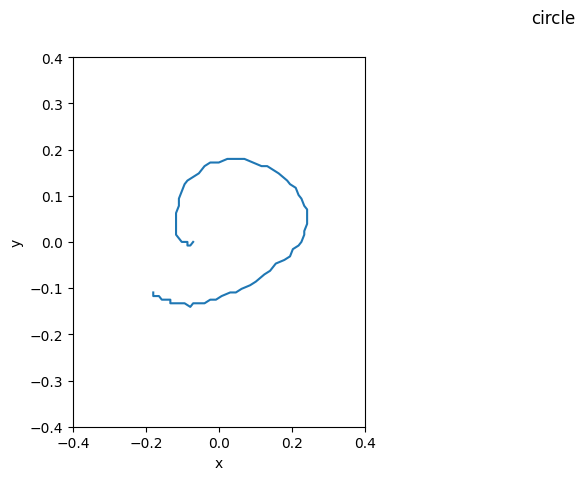

In [ ]:
plot_stroke(strokes_figure[11])

In [ ]:
import math
import numpy as np
import PIL

FIXED_POINT = 256

def mul_fp(a, b):
  return (a * b) / FIXED_POINT

def div_fp(a, b):
  if b == 0:
    b = 1
  return (a * FIXED_POINT) / b

def float_to_fp(a):
  return math.floor(a * FIXED_POINT)

def norm_to_coord_fp(a, range_fp, half_size_fp):
  a_fp = float_to_fp(a)
  norm_fp = div_fp(a_fp, range_fp)
  return mul_fp(norm_fp, half_size_fp) + half_size_fp

def round_fp_to_int(a):
  return math.floor((a + (FIXED_POINT / 2)) / FIXED_POINT)

def gate(a, min, max):
  if a < min:
    return min
  elif a > max:
    return max
  else:
    return a

def rasterize_stroke(stroke_points, x_range, y_range, width, height):
  num_channels = 3
  buffer_byte_count = height * width * num_channels
  buffer = bytearray(buffer_byte_count)

  width_fp = width * FIXED_POINT
  height_fp = height * FIXED_POINT
  half_width_fp = width_fp / 2
  half_height_fp = height_fp / 2
  x_range_fp = float_to_fp(x_range)
  y_range_fp = float_to_fp(y_range)

  t_inc_fp = FIXED_POINT / len(stroke_points)

  one_half_fp = (FIXED_POINT / 2)

  for point_index in range(len(stroke_points) - 1):
    start_point = stroke_points[point_index]
    end_point = stroke_points[point_index + 1]
    start_x_fp = norm_to_coord_fp(start_point["x"], x_range_fp, half_width_fp)
    start_y_fp = norm_to_coord_fp(-start_point["y"], y_range_fp, half_height_fp)
    end_x_fp = norm_to_coord_fp(end_point["x"], x_range_fp, half_width_fp)
    end_y_fp = norm_to_coord_fp(-end_point["y"], y_range_fp, half_height_fp)
    delta_x_fp = end_x_fp - start_x_fp
    delta_y_fp = end_y_fp - start_y_fp

    t_fp = point_index * t_inc_fp
    if t_fp < one_half_fp:
      local_t_fp = div_fp(t_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = round_fp_to_int(one_minus_t_fp * 255)
      green = round_fp_to_int(local_t_fp * 255)
      blue = 0
    else:
      local_t_fp = div_fp(t_fp - one_half_fp, one_half_fp)
      one_minus_t_fp = FIXED_POINT - local_t_fp
      red = 0
      green = round_fp_to_int(one_minus_t_fp * 255)
      blue = round_fp_to_int(local_t_fp * 255)
    red = gate(red, 0, 255)
    green = gate(green, 0, 255)
    blue = gate(blue, 0, 255)

    if abs(delta_x_fp) > abs(delta_y_fp):
      line_length = abs(round_fp_to_int(delta_x_fp))
      if delta_x_fp > 0:
        x_inc_fp = 1 * FIXED_POINT
        y_inc_fp = div_fp(delta_y_fp, delta_x_fp)
      else:
        x_inc_fp = -1 * FIXED_POINT
        y_inc_fp = -div_fp(delta_y_fp, delta_x_fp)
    else:
      line_length = abs(round_fp_to_int(delta_y_fp))
      if delta_y_fp > 0:
        y_inc_fp = 1 * FIXED_POINT
        x_inc_fp = div_fp(delta_x_fp, delta_y_fp)
      else:
        y_inc_fp = -1 * FIXED_POINT
        x_inc_fp = -div_fp(delta_x_fp, delta_y_fp)
    for i in range(line_length + 1):
      x_fp = start_x_fp + (i * x_inc_fp)
      y_fp = start_y_fp + (i * y_inc_fp)
      x = round_fp_to_int(x_fp)
      y = round_fp_to_int(y_fp)
      if (x < 0) or (x >= width) or (y < 0) or (y >= height):
        continue
      buffer_index = (y * width * num_channels) + (x * num_channels)
      buffer[buffer_index + 0] = red
      buffer[buffer_index + 1] = green
      buffer[buffer_index + 2] = blue

  np_buffer = np.frombuffer(buffer, dtype=np.uint8).reshape(height, width, num_channels)

  return np_buffer

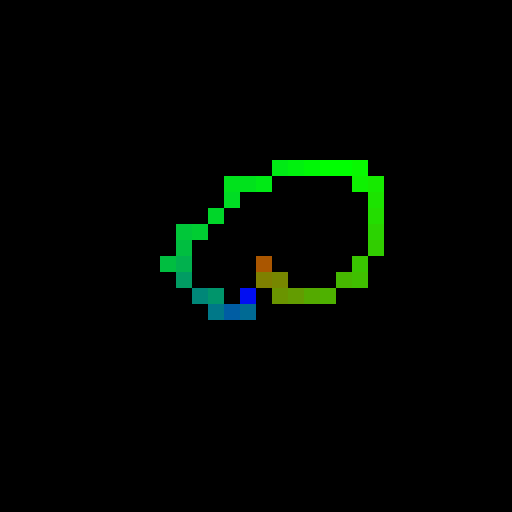

In [ ]:
raster = rasterize_stroke(strokes_alphabet[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

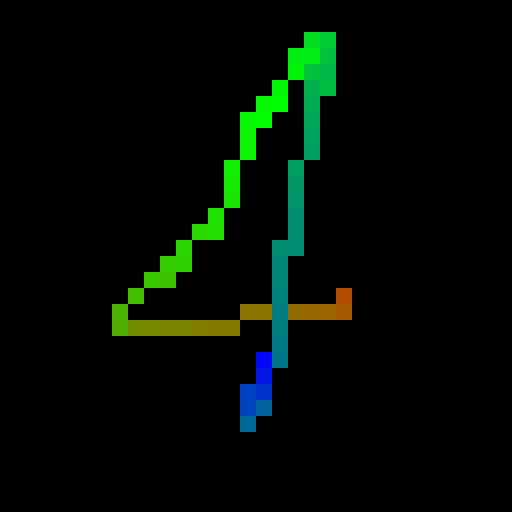

In [ ]:
raster = rasterize_stroke(strokes_digit[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

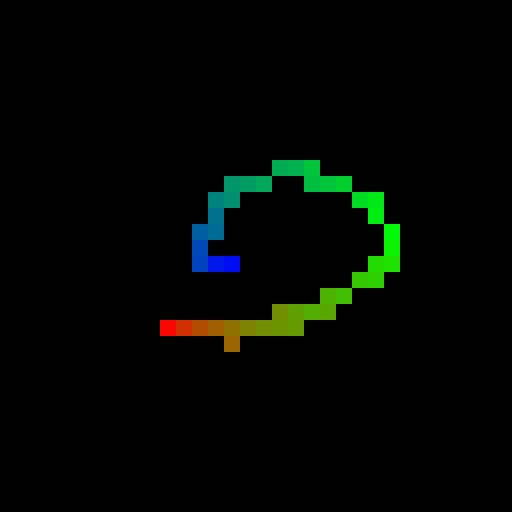

In [ ]:
raster = rasterize_stroke(strokes_figure[11]["strokePoints"], 0.5, 0.5, 32, 32)
PIL.Image.fromarray(raster).resize((512, 512), PIL.Image.NEAREST)

In [ ]:
from pathlib import Path
import shutil

X_RANGE = 0.6
Y_RANGE = 0.6

def ensure_empty_dir(dirname):
  dirpath = Path(dirname)
  if dirpath.exists() and dirpath.is_dir():
    shutil.rmtree(dirpath)
  dirpath.mkdir()

def augment_points(points, move_range, scale_range, rotate_range):
  move_x = np.random.uniform(low=-move_range, high=move_range)
  move_y = np.random.uniform(low=-move_range, high=move_range)
  scale = np.random.uniform(low=1.0-scale_range, high=1.0+scale_range)
  rotate = np.random.uniform(low=-rotate_range, high=rotate_range)

  x_axis_x = math.cos(rotate) * scale
  x_axis_y = math.sin(rotate) * scale

  y_axis_x = -math.sin(rotate) * scale
  y_axis_y = math.cos(rotate) * scale

  new_points = []
  for point in points:
    old_x = point["x"]
    old_y = point["y"]
    new_x = (x_axis_x * old_x) + (x_axis_y * old_y) + move_x
    new_y = (y_axis_x * old_x) + (y_axis_y * old_y) + move_y
    new_points.append({"x": new_x, "y": new_y})

  return new_points

def save_strokes_as_images(strokes, root_folder, width, height, augment_count):
  ensure_empty_dir(root_folder)
  labels = set()
  for stroke in strokes:
    labels.add(stroke["label"].lower())
  for label in labels:
    label_path = Path(root_folder, label)
    ensure_empty_dir(label_path)

  label_counts = {}
  for stroke in strokes:
    points = stroke["strokePoints"]
    label = stroke["label"].lower()
    if label == "":
      raise Exception("Missing label for %s:%d" % (stroke["filename"], stroke["index"]))
    if label not in label_counts:
      label_counts[label] = 0
    label_count = label_counts[label]
    label_counts[label] += 1
    raster = rasterize_stroke(points, X_RANGE, Y_RANGE, width, height)
    image = PIL.Image.fromarray(raster)
    image.save(Path(root_folder, label, str(label_count) + ".png"))
    for i in range(augment_count):
      augmented_points = augment_points(points, 0.1, 0.1, 0.3)
      raster = rasterize_stroke(augmented_points, X_RANGE, Y_RANGE, width, height)
      image = PIL.Image.fromarray(raster)
      image.save(Path(root_folder, label, str(label_count) + "_a" + str(i) + ".png"))


In [ ]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# alphabet 데이터 이미지 생성

shuffled_strokes = strokes_alphabet
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test_alphabet", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation_alphabet", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train_alphabet", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [ ]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# digit 데이터 이미지 생성

shuffled_strokes = strokes_digit
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test_digit", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation_digit", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train_digit", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [ ]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32

# figure 데이터 이미지 생성

shuffled_strokes = strokes_figure
np.random.shuffle(shuffled_strokes)

test_percentage = 10
validation_percentage = 10
train_percentage = 100 - (test_percentage + validation_percentage)

test_count = math.floor((len(shuffled_strokes) * test_percentage) / 100)
validation_count = math.floor((len(shuffled_strokes) * validation_percentage) / 100)
test_strokes = shuffled_strokes[0:test_count]
validation_strokes = shuffled_strokes[test_count:(test_count + validation_count)]
train_strokes = shuffled_strokes[(test_count + validation_count):]

save_strokes_as_images(test_strokes, "test_figure", IMAGE_WIDTH, IMAGE_HEIGHT, 10)
save_strokes_as_images(validation_strokes, "validation_figure", IMAGE_WIDTH, IMAGE_HEIGHT, 0)
save_strokes_as_images(train_strokes, "train_figure", IMAGE_WIDTH, IMAGE_HEIGHT, 10)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory

# 알파벳
validation_ds_alphabet = image_dataset_from_directory(
    directory='validation_alphabet',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds_alphabet = image_dataset_from_directory(
    directory='train_alphabet',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

# 숫자
validation_ds_digit = image_dataset_from_directory(
    directory='validation_digit',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds_digit = image_dataset_from_directory(
    directory='train_digit',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

# 도형
validation_ds_figure = image_dataset_from_directory(
    directory='validation_figure',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)

train_ds_figure = image_dataset_from_directory(
    directory='train_figure',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT)).prefetch(buffer_size=32)


Found 10 files belonging to 2 classes.
Found 946 files belonging to 2 classes.
Found 100 files belonging to 10 classes.
Found 8800 files belonging to 10 classes.
Found 15 files belonging to 3 classes.
Found 1419 files belonging to 3 classes.


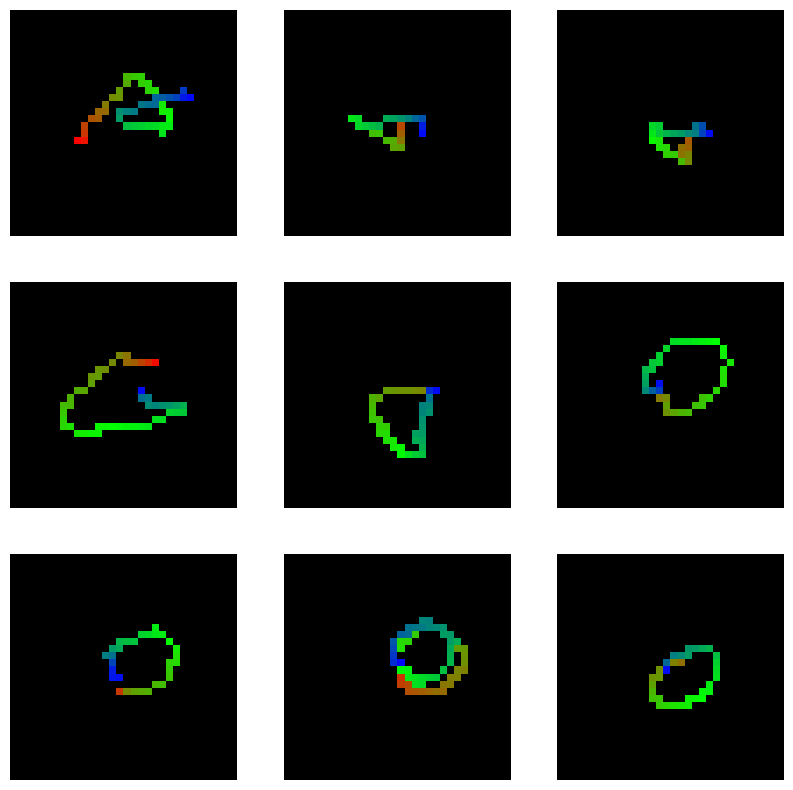

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_alphabet.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

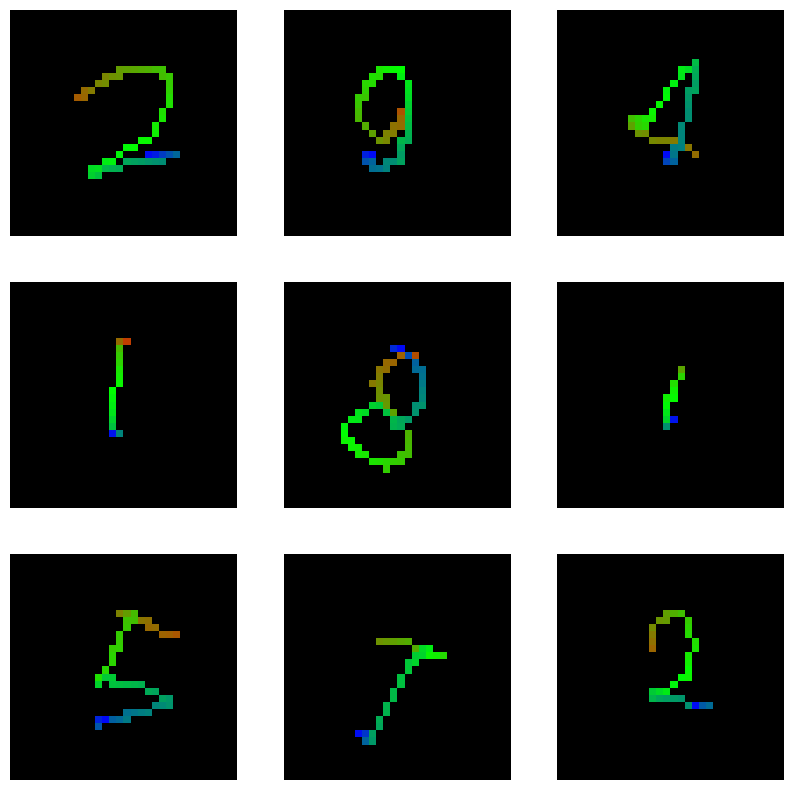

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_digit.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

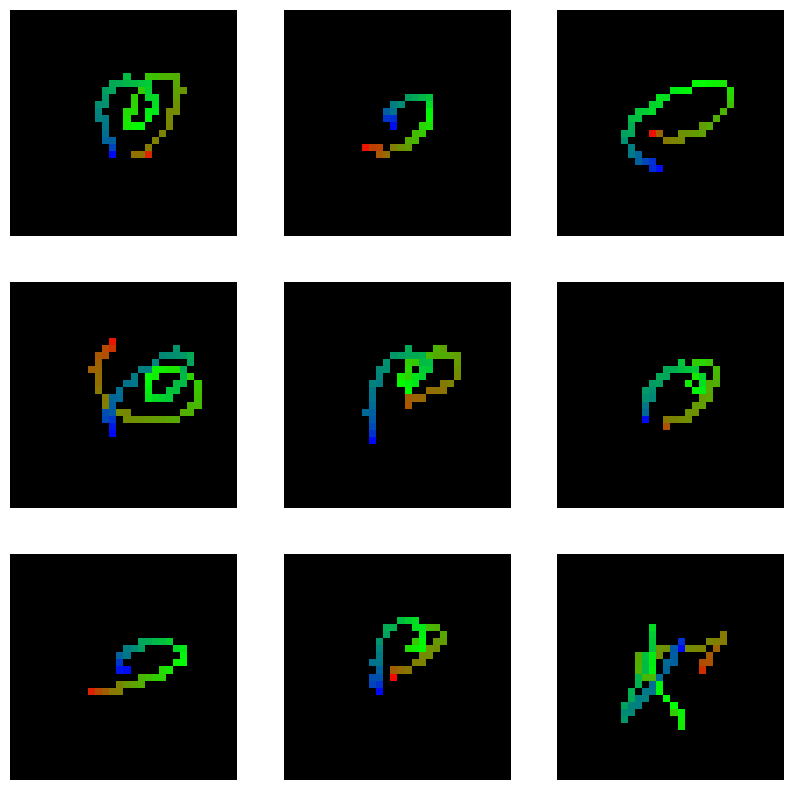

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_figure.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
from keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

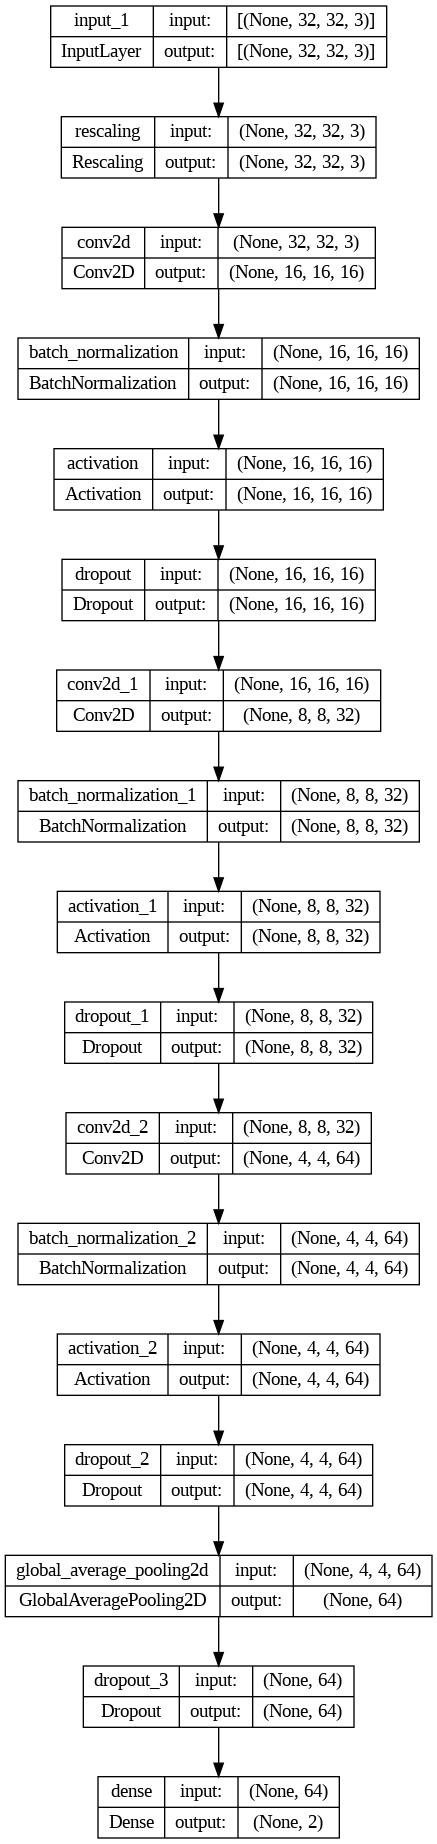

In [ ]:
model_alphabet = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=2)
keras.utils.plot_model(model_alphabet, show_shapes=True)

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_alphabet_at_{epoch}.h5"),
]
model_alphabet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_alphabet.fit(
    train_ds_alphabet, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_alphabet,
)

Epoch 1/30
30/30 [==============================] - 4s 36ms/step - loss: 0.7116 - accuracy: 0.5613 - val_loss: 0.6710 - val_accuracy: 0.7000
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 1s 43ms/step - loss: 0.6656 - accuracy: 0.6311 - val_loss: 0.6389 - val_accuracy: 0.7000
Epoch 3/30
30/30 [==============================] - 2s 47ms/step - loss: 0.6250 - accuracy: 0.6839 - val_loss: 0.6116 - val_accuracy: 0.7000
Epoch 4/30
30/30 [==============================] - 1s 19ms/step - loss: 0.6224 - accuracy: 0.6860 - val_loss: 0.5963 - val_accuracy: 0.7000
Epoch 5/30
30/30 [==============================] - 1s 19ms/step - loss: 0.5793 - accuracy: 0.7252 - val_loss: 0.5865 - val_accuracy: 0.7000
Epoch 6/30
30/30 [==============================] - 1s 18ms/step - loss: 0.5323 - accuracy: 0.7611 - val_loss: 0.5849 - val_accuracy: 0.7000
Epoch 7/30
30/30 [==============================] - 1s 19ms/step - loss: 0.4962 - accuracy: 0.7833 - val_loss: 0.5784 - val_accuracy: 0.7000
Epoch 8/30
30/30 [==============================] - 1s 18ms/step - loss: 0.4665 - accuracy: 0.8013 - val_loss: 0.5689 - val_accuracy: 0.7000
Epoch 9/30
30/30 [======

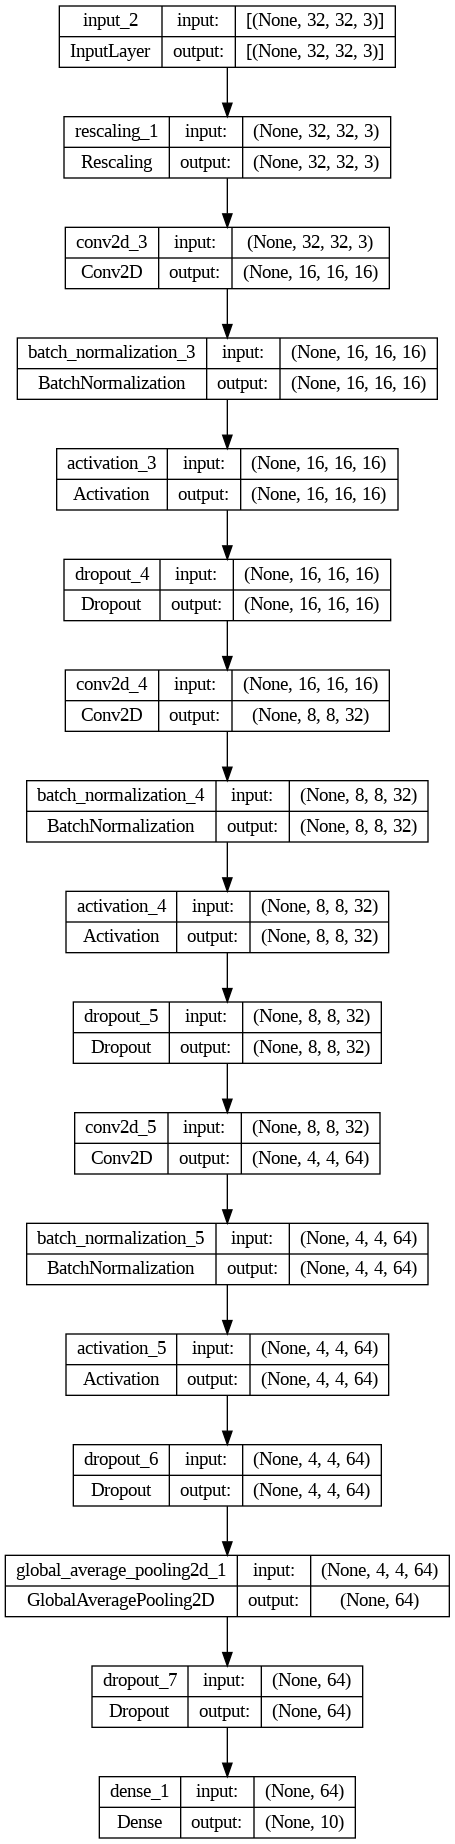

In [ ]:
model_digit = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=10)
keras.utils.plot_model(model_digit, show_shapes=True)

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_digit_at_{epoch}.h5"),
]
model_digit.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_digit.fit(
    train_ds_digit, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_digit,
)

Epoch 1/30
275/275 [==============================] - 8s 22ms/step - loss: 0.3667 - accuracy: 0.1449 - val_loss: 0.3323 - val_accuracy: 0.1600
Epoch 2/30
  1/275 [..............................] - ETA: 28s - loss: 0.3098 - accuracy: 0.2812

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


275/275 [==============================] - 6s 21ms/step - loss: 0.3092 - accuracy: 0.2455 - val_loss: 0.2794 - val_accuracy: 0.3200
Epoch 3/30
275/275 [==============================] - 7s 24ms/step - loss: 0.2885 - accuracy: 0.3022 - val_loss: 0.2246 - val_accuracy: 0.6700
Epoch 4/30
275/275 [==============================] - 5s 18ms/step - loss: 0.2688 - accuracy: 0.3752 - val_loss: 0.2063 - val_accuracy: 0.7300
Epoch 5/30
275/275 [==============================] - 7s 24ms/step - loss: 0.2504 - accuracy: 0.4462 - val_loss: 0.1779 - val_accuracy: 0.8900
Epoch 6/30
275/275 [==============================] - 5s 19ms/step - loss: 0.2364 - accuracy: 0.4932 - val_loss: 0.1618 - val_accuracy: 0.9300
Epoch 7/30
275/275 [==============================] - 5s 19ms/step - loss: 0.2217 - accuracy: 0.5407 - val_loss: 0.1610 - val_accuracy: 0.9200
Epoch 8/30
275/275 [==============================] - 6s 21ms/step - loss: 0.2111 - accuracy: 0.5794 - val_loss: 0.1425 - val_accuracy: 0.9200
Epoch 9/30

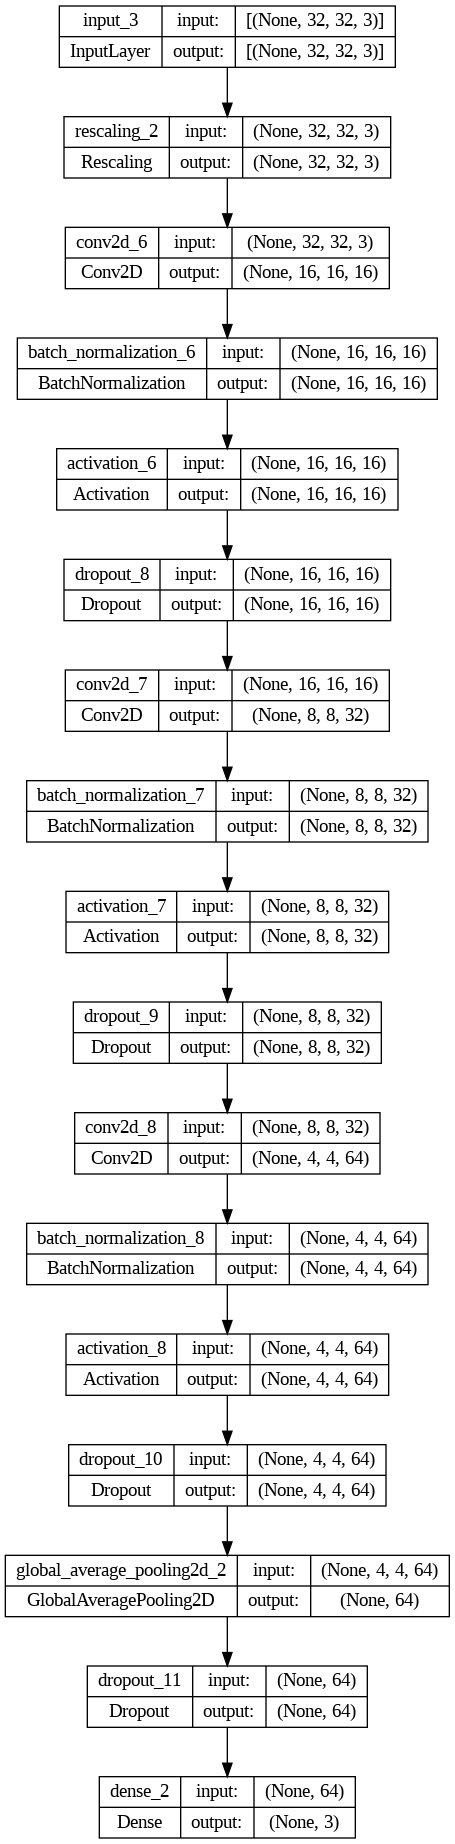

In [ ]:
model_figure = make_model(input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes=3)
keras.utils.plot_model(model_figure, show_shapes=True)

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoints/save_figure_at_{epoch}.h5"),
]
model_figure.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_figure.fit(
    train_ds_figure, epochs=epochs, callbacks=callbacks, validation_data=validation_ds_figure,
)

Epoch 1/30
45/45 [==============================] - 3s 22ms/step - loss: 0.6760 - accuracy: 0.3834 - val_loss: 0.6494 - val_accuracy: 0.4667
Epoch 2/30
 3/45 [=>............................] - ETA: 1s - loss: 0.6218 - accuracy: 0.4688

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 1s 19ms/step - loss: 0.6018 - accuracy: 0.5046 - val_loss: 0.6151 - val_accuracy: 0.4667
Epoch 3/30
45/45 [==============================] - 1s 19ms/step - loss: 0.5819 - accuracy: 0.5426 - val_loss: 0.6056 - val_accuracy: 0.4667
Epoch 4/30
45/45 [==============================] - 1s 18ms/step - loss: 0.5565 - accuracy: 0.5722 - val_loss: 0.6092 - val_accuracy: 0.4667
Epoch 5/30
45/45 [==============================] - 1s 18ms/step - loss: 0.5374 - accuracy: 0.5891 - val_loss: 0.6098 - val_accuracy: 0.4667
Epoch 6/30
45/45 [==============================] - 1s 18ms/step - loss: 0.5193 - accuracy: 0.6371 - val_loss: 0.6038 - val_accuracy: 0.4667
Epoch 7/30
45/45 [==============================] - 1s 27ms/step - loss: 0.4911 - accuracy: 0.6526 - val_loss: 0.5780 - val_accuracy: 0.4667
Epoch 8/30
45/45 [==============================] - 1s 21ms/step - loss: 0.4691 - accuracy: 0.6815 - val_loss: 0.5244 - val_accuracy: 0.4667
Epoch 9/30
45/45 [======

이제부터 flag 분류 시작

In [ ]:
def predict_image(filename, flag):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  if flag == 1:
    predictions = model_digit.predict(img_array).flatten()
  elif flag == 2:
    predictions = model_figure.predict(img_array).flatten()
  else:
    predictions = model_alphabet.predict(img_array).flatten()
  predicted_label_index = np.argmax(predictions)
  predicted_score = predictions[predicted_label_index]
  return (predicted_label_index, predicted_score)

index, score = predict_image("test_figure/star/0.png", 2)

print(index, score)

1/1 [==============================] - 0s 25ms/step
2 0.9995968


In [ ]:
model_digit.save(SAVED_MODEL_DIGIT_FILENAME)
model_figure.save(SAVED_MODEL_FIGURE_FILENAME)
model_alphabet.save(SAVED_MODEL_ALPHABET_FILENAME)

In [ ]:
# 숫자 모델 변환

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIGIT_FILENAME)
model_no_quant_tflite_digit = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_DIGIT_FILENAME, "wb").write(model_no_quant_tflite_digit)

def representative_dataset():
  for filename in glob.glob("test_digit/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite_digit = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_DIGIT_FILENAME, "wb").write(model_tflite_digit)

31424

In [ ]:
# 도형 모델 변환

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FIGURE_FILENAME)
model_no_quant_tflite_figure = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_FIGURE_FILENAME, "wb").write(model_no_quant_tflite_figure)

def representative_dataset():
  for filename in glob.glob("test_figure/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite_figure = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_FIGURE_FILENAME, "wb").write(model_tflite_figure)

30952

In [ ]:
# 알파벳 모델 변환

converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_ALPHABET_FILENAME)
model_no_quant_tflite_alphabet = converter.convert()

# Save the model to disk
open(FLOAT_TFL_MODEL_ALPHABET_FILENAME, "wb").write(model_no_quant_tflite_alphabet)

def representative_dataset():
  for filename in glob.glob("test_alphabet/*/*.png"):
    img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis      for images, labels in train_ds.take(1):
    yield([img_array])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite_alphabet = converter.convert()

# Save the model to disk
open(QUANTIZED_TFL_MODEL_ALPHABET_FILENAME, "wb").write(model_tflite_alphabet)

30760

In [ ]:
def predict_tflite(tflite_model, filename):
  img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    img_array = np.multiply(img_array, 1.0 / input_scale) + input_zero_point
    img_array = img_array.astype(input_details["dtype"])

  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], img_array)
  interpreter.invoke()
  pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    pred = pred.astype(np.float32)
    pred = np.multiply((pred - output_zero_point), output_scale)

  predicted_label_index = np.argmax(pred)
  predicted_score = pred[predicted_label_index]
  return (predicted_label_index, predicted_score)

In [ ]:
predict_tflite(model_tflite_digit, "test_digit/2/1.png")

(2, 0.97265625)

In [ ]:
predict_tflite(model_tflite_figure, "test_figure/heart/1.png")

(1, 0.828125)

In [ ]:
predict_tflite(model_tflite_alphabet, "test_alphabet/a/0.png")

(0, 0.99609375)

test_digit/7 expected, 7 found with score 0.914062


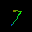

test_digit/7 expected, 7 found with score 0.894531


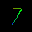

test_digit/7 expected, 7 found with score 0.941406


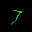

test_digit/7 expected, 7 found with score 0.785156


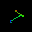

test_digit/7 expected, 7 found with score 0.960938


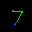

test_digit/7 expected, 7 found with score 0.796875


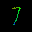

test_digit/7 expected, 7 found with score 0.984375


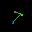

test_digit/7 expected, 7 found with score 0.953125


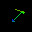

test_digit/7 expected, 7 found with score 0.988281


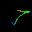

test_digit/7 expected, 7 found with score 0.882812


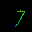

test_digit/7 expected, 7 found with score 0.902344


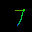

test_digit/7 expected, 7 found with score 0.949219


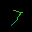

test_digit/7 expected, 7 found with score 0.875000


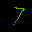

test_digit/7 expected, 7 found with score 0.980469


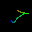

test_digit/7 expected, 7 found with score 0.937500


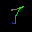

test_digit/7 expected, 7 found with score 0.976562


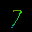

test_digit/7 expected, 7 found with score 0.875000


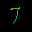

test_digit/7 expected, 7 found with score 0.988281


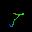

test_digit/7 expected, 7 found with score 0.894531


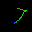

test_digit/7 expected, 7 found with score 0.902344


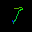

test_digit/7 expected, 7 found with score 0.894531


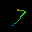

test_digit/7 expected, 7 found with score 0.957031


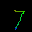

test_digit/7 expected, 7 found with score 0.968750


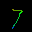

test_digit/7 expected, 7 found with score 0.980469


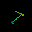

test_digit/7 expected, 7 found with score 0.910156


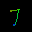

test_digit/7 expected, 7 found with score 0.867188


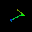

test_digit/7 expected, 7 found with score 0.984375


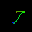

test_digit/7 expected, 7 found with score 0.972656


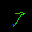

test_digit/7 expected, 7 found with score 0.992188


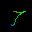

test_digit/7 expected, 7 found with score 0.972656


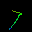

test_digit/7 expected, 7 found with score 0.941406


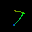

test_digit/7 expected, 7 found with score 0.960938


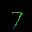

test_digit/7 expected, 7 found with score 0.925781


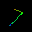

test_digit/7 expected, 7 found with score 0.894531


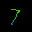

test_digit/7 expected, 7 found with score 0.984375


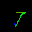

test_digit/7 expected, 7 found with score 0.898438


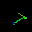

test_digit/7 expected, 7 found with score 0.960938


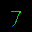

test_digit/7 expected, 7 found with score 0.894531


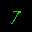

test_digit/7 expected, 7 found with score 0.851562


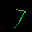

test_digit/7 expected, 7 found with score 0.953125


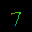

test_digit/7 expected, 7 found with score 0.984375


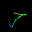

test_digit/7 expected, 7 found with score 0.992188


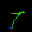

test_digit/7 expected, 7 found with score 0.945312


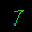

test_digit/7 expected, 7 found with score 0.929688


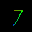

test_digit/7 expected, 7 found with score 0.906250


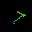

test_digit/7 expected, 7 found with score 0.980469


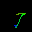

test_digit/7 expected, 7 found with score 0.925781


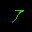

test_digit/7 expected, 7 found with score 0.929688


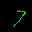

test_digit/7 expected, 7 found with score 0.933594


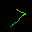

test_digit/7 expected, 7 found with score 0.929688


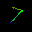

test_digit/7 expected, 7 found with score 0.894531


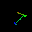

test_digit/7 expected, 7 found with score 0.917969


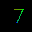

test_digit/7 expected, 7 found with score 0.945312


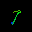

test_digit/7 expected, 7 found with score 0.949219


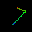

test_digit/7 expected, 7 found with score 0.968750


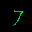

test_digit/7 expected, 7 found with score 0.882812


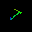

test_digit/7 expected, 7 found with score 0.968750


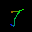

test_digit/7 expected, 7 found with score 0.980469


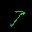

test_digit/7 expected, 7 found with score 0.980469


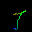

test_digit/7 expected, 7 found with score 0.992188


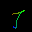

test_digit/7 expected, 7 found with score 0.910156


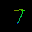

test_digit/7 expected, 7 found with score 0.957031


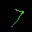

test_digit/7 expected, 7 found with score 0.917969


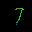

test_digit/7 expected, 7 found with score 0.960938


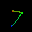

test_digit/7 expected, 7 found with score 0.906250


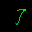

test_digit/7 expected, 7 found with score 0.941406


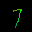

test_digit/7 expected, 7 found with score 0.992188


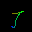

test_digit/7 expected, 7 found with score 0.945312


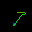

test_digit/7 expected, 7 found with score 0.976562


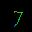

test_digit/7 expected, 7 found with score 0.910156


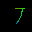

test_digit/7 expected, 7 found with score 0.937500


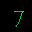

test_digit/7 expected, 7 found with score 0.984375


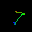

test_digit/7 expected, 7 found with score 0.808594


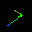

test_digit/7 expected, 7 found with score 0.949219


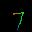

test_digit/7 expected, 7 found with score 0.937500


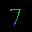

test_digit/7 expected, 7 found with score 0.792969


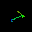

test_digit/7 expected, 7 found with score 0.984375


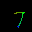

test_digit/7 expected, 7 found with score 0.945312


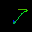

test_digit/3 expected, 3 found with score 0.835938


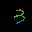

test_digit/3 expected, 3 found with score 0.769531


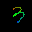

test_digit/3 expected, 3 found with score 0.765625


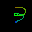

test_digit/3 expected, 3 found with score 0.937500


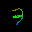

test_digit/3 expected, 3 found with score 0.921875


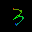

test_digit/3 expected, 3 found with score 0.906250


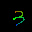

test_digit/3 expected, 3 found with score 0.859375


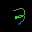

test_digit/3 expected, 3 found with score 0.902344


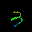

test_digit/3 expected, 3 found with score 0.855469


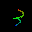

test_digit/3 expected, 3 found with score 0.761719


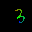

test_digit/3 expected, 3 found with score 0.914062


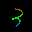

test_digit/3 expected, 3 found with score 0.871094


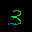

test_digit/3 expected, 3 found with score 0.816406


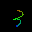

test_digit/3 expected, 3 found with score 0.816406


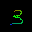

test_digit/3 expected, 3 found with score 0.804688


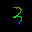

test_digit/3 expected, 3 found with score 0.812500


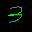

test_digit/3 expected, 3 found with score 0.890625


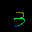

test_digit/3 expected, 3 found with score 0.878906


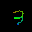

test_digit/3 expected, 3 found with score 0.847656


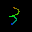

test_digit/3 expected, 3 found with score 0.843750


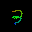

test_digit/3 expected, 3 found with score 0.863281


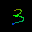

test_digit/3 expected, 3 found with score 0.753906


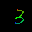

test_digit/3 expected, 3 found with score 0.777344


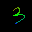

test_digit/3 expected, 3 found with score 0.910156


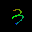

test_digit/3 expected, 3 found with score 0.781250


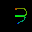

test_digit/3 expected, 3 found with score 0.839844


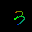

test_digit/3 expected, 3 found with score 0.769531


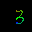

test_digit/3 expected, 3 found with score 0.769531


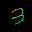

test_digit/3 expected, 3 found with score 0.902344


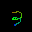

test_digit/3 expected, 3 found with score 0.953125


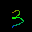

test_digit/3 expected, 3 found with score 0.750000


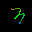

test_digit/3 expected, 3 found with score 0.945312


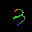

test_digit/3 expected, 3 found with score 0.949219


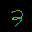

test_digit/3 expected, 3 found with score 0.781250


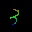

test_digit/3 expected, 3 found with score 0.816406


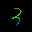

test_digit/3 expected, 3 found with score 0.804688


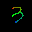

test_digit/3 expected, 3 found with score 0.925781


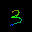

test_digit/3 expected, 3 found with score 0.753906


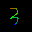

test_digit/3 expected, 3 found with score 0.839844


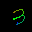

test_digit/3 expected, 3 found with score 0.835938


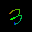

test_digit/3 expected, 3 found with score 0.800781


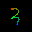

test_digit/3 expected, 3 found with score 0.796875


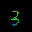

test_digit/5 expected, 5 found with score 0.785156


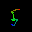

test_digit/5 expected, 5 found with score 0.960938


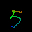

test_digit/5 expected, 5 found with score 0.937500


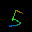

test_digit/5 expected, 5 found with score 0.964844


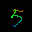

test_digit/5 expected, 5 found with score 0.957031


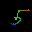

test_digit/5 expected, 5 found with score 0.949219


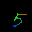

test_digit/5 expected, 5 found with score 0.945312


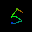

test_digit/5 expected, 5 found with score 0.921875


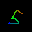

test_digit/5 expected, 5 found with score 0.925781


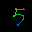

test_digit/5 expected, 5 found with score 0.976562


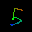

test_digit/5 expected, 5 found with score 0.980469


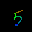

test_digit/5 expected, 5 found with score 0.921875


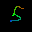

test_digit/5 expected, 5 found with score 0.960938


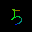

test_digit/5 expected, 5 found with score 0.914062


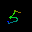

test_digit/5 expected, 5 found with score 0.953125


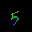

test_digit/5 expected, 5 found with score 0.890625


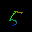

test_digit/5 expected, 5 found with score 0.839844


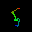

test_digit/5 expected, 5 found with score 0.968750


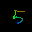

test_digit/5 expected, 5 found with score 0.917969


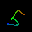

test_digit/5 expected, 5 found with score 0.968750


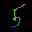

test_digit/5 expected, 5 found with score 0.789062


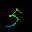

test_digit/5 expected, 5 found with score 0.957031


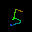

test_digit/5 expected, 5 found with score 0.875000


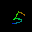

test_digit/5 expected, 5 found with score 0.976562


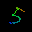

test_digit/5 expected, 5 found with score 0.976562


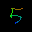

test_digit/5 expected, 5 found with score 0.976562


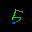

test_digit/5 expected, 5 found with score 0.878906


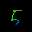

test_digit/5 expected, 5 found with score 0.804688


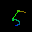

test_digit/5 expected, 5 found with score 0.964844


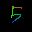

test_digit/5 expected, 5 found with score 0.984375


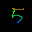

test_digit/5 expected, 5 found with score 0.945312


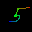

test_digit/5 expected, 5 found with score 0.996094


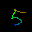

test_digit/5 expected, 5 found with score 0.839844


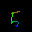

test_digit/5 expected, 5 found with score 0.992188


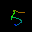

test_digit/5 expected, 5 found with score 0.820312


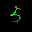

test_digit/5 expected, 5 found with score 0.984375


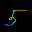

test_digit/5 expected, 5 found with score 0.785156


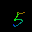

test_digit/5 expected, 5 found with score 0.820312


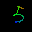

test_digit/5 expected, 5 found with score 0.886719


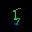

test_digit/5 expected, 5 found with score 0.890625


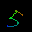

test_digit/5 expected, 5 found with score 0.941406


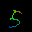

test_digit/5 expected, 5 found with score 0.796875


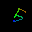

test_digit/5 expected, 5 found with score 0.968750


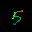

test_digit/5 expected, 5 found with score 0.914062


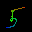

test_digit/5 expected, 5 found with score 0.960938


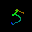

test_digit/5 expected, 5 found with score 0.769531


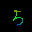

test_digit/5 expected, 5 found with score 0.980469


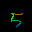

test_digit/5 expected, 5 found with score 0.914062


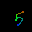

test_digit/5 expected, 5 found with score 0.941406


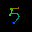

test_digit/5 expected, 5 found with score 0.964844


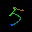

test_digit/5 expected, 5 found with score 0.859375


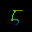

test_digit/5 expected, 5 found with score 0.949219


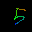

test_digit/5 expected, 5 found with score 0.984375


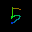

test_digit/5 expected, 5 found with score 0.976562


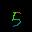

test_digit/5 expected, 5 found with score 0.972656


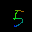

test_digit/5 expected, 5 found with score 0.968750


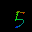

test_digit/5 expected, 5 found with score 0.941406


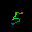

test_digit/5 expected, 5 found with score 0.945312


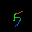

test_digit/5 expected, 5 found with score 0.894531


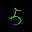

test_digit/5 expected, 5 found with score 0.984375


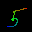

test_digit/5 expected, 5 found with score 0.917969


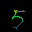

test_digit/5 expected, 5 found with score 0.824219


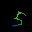

test_digit/5 expected, 5 found with score 0.859375


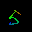

test_digit/5 expected, 5 found with score 0.777344


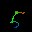

test_digit/5 expected, 5 found with score 0.929688


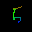

test_digit/5 expected, 5 found with score 0.925781


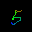

test_digit/5 expected, 5 found with score 0.972656


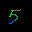

test_digit/5 expected, 5 found with score 0.792969


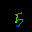

test_digit/5 expected, 5 found with score 0.789062


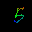

test_digit/5 expected, 5 found with score 0.937500


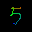

test_digit/5 expected, 5 found with score 0.964844


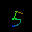

test_digit/5 expected, 5 found with score 0.980469


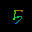

test_digit/5 expected, 5 found with score 0.902344


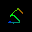

test_digit/5 expected, 5 found with score 0.972656


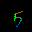

test_digit/5 expected, 5 found with score 0.859375


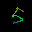

test_digit/5 expected, 5 found with score 0.937500


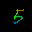

test_digit/5 expected, 5 found with score 0.933594


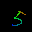

test_digit/5 expected, 5 found with score 0.937500


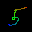

test_digit/5 expected, 5 found with score 0.972656


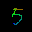

test_digit/5 expected, 5 found with score 0.980469


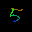

test_digit/5 expected, 5 found with score 0.945312


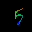

test_digit/5 expected, 5 found with score 0.945312


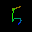

test_digit/5 expected, 5 found with score 0.828125


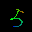

test_digit/5 expected, 5 found with score 0.800781


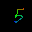

test_digit/5 expected, 5 found with score 0.902344


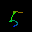

test_digit/5 expected, 5 found with score 0.875000


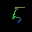

test_digit/5 expected, 5 found with score 0.976562


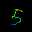

test_digit/5 expected, 5 found with score 0.972656


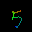

test_digit/5 expected, 5 found with score 0.988281


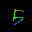

test_digit/5 expected, 5 found with score 0.925781


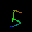

test_digit/5 expected, 5 found with score 0.988281


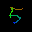

test_digit/5 expected, 5 found with score 0.917969


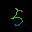

test_digit/5 expected, 5 found with score 0.972656


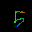

test_digit/5 expected, 5 found with score 0.980469


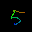

test_digit/5 expected, 5 found with score 0.906250


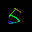

test_digit/5 expected, 5 found with score 0.855469


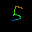

test_digit/5 expected, 5 found with score 0.972656


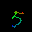

test_digit/5 expected, 5 found with score 0.980469


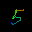

test_digit/5 expected, 5 found with score 0.839844


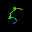

test_digit/5 expected, 3 found with score 0.800781


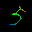

test_digit/5 expected, 5 found with score 0.976562


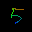

test_digit/5 expected, 5 found with score 0.789062


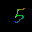

test_digit/5 expected, 5 found with score 0.937500


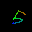

test_digit/5 expected, 5 found with score 0.890625


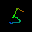

test_digit/5 expected, 5 found with score 0.933594


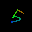

test_digit/5 expected, 5 found with score 0.957031


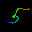

test_digit/5 expected, 5 found with score 0.859375


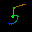

test_digit/5 expected, 5 found with score 0.945312


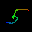

test_digit/5 expected, 5 found with score 0.972656


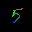

test_digit/5 expected, 5 found with score 0.882812


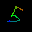

test_digit/5 expected, 5 found with score 0.976562


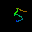

test_digit/5 expected, 5 found with score 0.917969


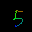

test_digit/5 expected, 5 found with score 0.878906


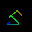

test_digit/5 expected, 5 found with score 0.949219


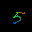

test_digit/5 expected, 5 found with score 0.937500


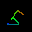

test_digit/5 expected, 5 found with score 0.937500


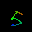

test_digit/5 expected, 5 found with score 0.820312


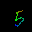

test_digit/9 expected, 9 found with score 0.980469


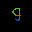

test_digit/9 expected, 9 found with score 0.996094


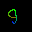

test_digit/9 expected, 9 found with score 0.968750


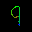

test_digit/9 expected, 9 found with score 0.980469


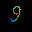

test_digit/9 expected, 9 found with score 0.964844


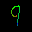

test_digit/9 expected, 9 found with score 0.773438


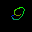

test_digit/9 expected, 9 found with score 0.972656


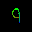

test_digit/9 expected, 9 found with score 0.992188


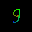

test_digit/9 expected, 9 found with score 0.949219


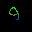

test_digit/9 expected, 9 found with score 0.917969


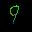

test_digit/9 expected, 9 found with score 0.906250


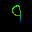

test_digit/9 expected, 9 found with score 0.992188


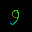

test_digit/9 expected, 9 found with score 0.937500


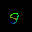

test_digit/9 expected, 9 found with score 0.980469


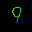

test_digit/9 expected, 9 found with score 0.976562


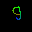

test_digit/9 expected, 9 found with score 0.996094


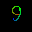

test_digit/9 expected, 9 found with score 0.816406


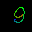

test_digit/9 expected, 9 found with score 0.992188


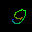

test_digit/9 expected, 9 found with score 0.925781


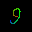

test_digit/9 expected, 9 found with score 0.996094


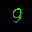

test_digit/9 expected, 9 found with score 0.996094


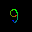

test_digit/9 expected, 9 found with score 0.949219


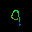

test_digit/9 expected, 9 found with score 0.972656


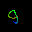

test_digit/9 expected, 9 found with score 0.996094


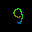

test_digit/9 expected, 9 found with score 0.886719


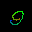

test_digit/9 expected, 9 found with score 0.980469


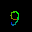

test_digit/9 expected, 9 found with score 0.898438


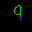

test_digit/9 expected, 9 found with score 0.992188


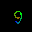

test_digit/9 expected, 9 found with score 0.984375


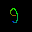

test_digit/9 expected, 9 found with score 0.992188


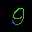

test_digit/9 expected, 9 found with score 0.988281


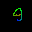

test_digit/9 expected, 9 found with score 0.992188


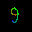

test_digit/9 expected, 9 found with score 0.976562


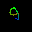

test_digit/9 expected, 9 found with score 0.996094


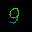

test_digit/9 expected, 9 found with score 0.996094


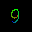

test_digit/9 expected, 9 found with score 0.992188


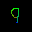

test_digit/9 expected, 9 found with score 0.980469


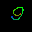

test_digit/9 expected, 9 found with score 0.937500


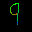

test_digit/9 expected, 9 found with score 0.996094


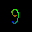

test_digit/9 expected, 9 found with score 0.992188


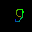

test_digit/9 expected, 9 found with score 0.953125


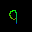

test_digit/9 expected, 9 found with score 0.910156


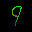

test_digit/9 expected, 9 found with score 0.910156


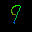

test_digit/9 expected, 9 found with score 0.972656


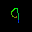

test_digit/9 expected, 9 found with score 0.949219


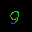

test_digit/9 expected, 9 found with score 0.984375


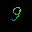

test_digit/9 expected, 9 found with score 0.988281


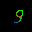

test_digit/9 expected, 9 found with score 0.972656


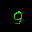

test_digit/9 expected, 9 found with score 0.988281


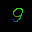

test_digit/9 expected, 9 found with score 0.992188


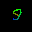

test_digit/9 expected, 9 found with score 0.882812


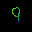

test_digit/9 expected, 9 found with score 0.996094


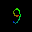

test_digit/9 expected, 9 found with score 0.984375


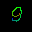

test_digit/9 expected, 9 found with score 0.976562


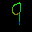

test_digit/9 expected, 9 found with score 0.992188


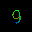

test_digit/9 expected, 9 found with score 0.980469


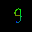

test_digit/9 expected, 9 found with score 0.992188


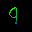

test_digit/9 expected, 9 found with score 0.988281


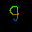

test_digit/9 expected, 9 found with score 0.984375


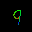

test_digit/9 expected, 9 found with score 0.984375


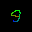

test_digit/9 expected, 9 found with score 0.996094


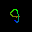

test_digit/9 expected, 9 found with score 0.968750


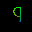

test_digit/9 expected, 9 found with score 0.984375


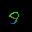

test_digit/9 expected, 9 found with score 0.992188


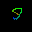

test_digit/9 expected, 9 found with score 0.996094


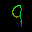

test_digit/9 expected, 9 found with score 0.988281


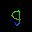

test_digit/9 expected, 9 found with score 0.945312


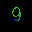

test_digit/9 expected, 9 found with score 0.992188


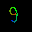

test_digit/9 expected, 9 found with score 0.937500


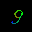

test_digit/9 expected, 9 found with score 0.933594


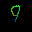

test_digit/9 expected, 9 found with score 0.945312


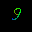

test_digit/9 expected, 9 found with score 0.988281


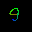

test_digit/9 expected, 9 found with score 0.992188


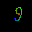

test_digit/9 expected, 9 found with score 0.988281


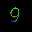

test_digit/9 expected, 9 found with score 0.988281


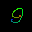

test_digit/9 expected, 9 found with score 0.925781


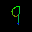

test_digit/9 expected, 9 found with score 0.996094


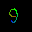

test_digit/9 expected, 9 found with score 0.976562


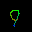

test_digit/9 expected, 9 found with score 0.996094


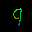

test_digit/9 expected, 9 found with score 0.988281


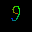

test_digit/9 expected, 9 found with score 0.988281


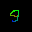

test_digit/9 expected, 9 found with score 0.898438


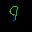

test_digit/9 expected, 9 found with score 0.914062


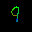

test_digit/9 expected, 9 found with score 0.996094


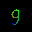

test_digit/9 expected, 9 found with score 0.996094


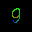

test_digit/9 expected, 9 found with score 0.957031


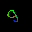

test_digit/9 expected, 9 found with score 0.957031


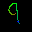

test_digit/9 expected, 9 found with score 0.988281


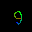

test_digit/9 expected, 9 found with score 0.976562


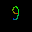

test_digit/9 expected, 9 found with score 0.996094


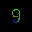

test_digit/9 expected, 9 found with score 0.949219


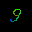

test_digit/9 expected, 9 found with score 0.949219


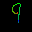

test_digit/9 expected, 9 found with score 0.988281


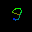

test_digit/9 expected, 9 found with score 0.941406


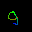

test_digit/9 expected, 9 found with score 0.984375


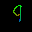

test_digit/9 expected, 9 found with score 0.949219


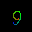

test_digit/9 expected, 9 found with score 0.980469


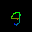

test_digit/9 expected, 9 found with score 0.996094


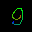

test_digit/9 expected, 9 found with score 0.871094


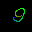

test_digit/9 expected, 9 found with score 0.984375


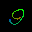

test_digit/9 expected, 9 found with score 0.992188


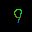

test_digit/9 expected, 9 found with score 0.996094


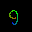

test_digit/9 expected, 9 found with score 0.976562


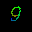

test_digit/9 expected, 9 found with score 0.882812


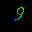

test_digit/9 expected, 9 found with score 0.988281


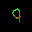

test_digit/9 expected, 9 found with score 0.996094


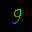

test_digit/9 expected, 9 found with score 0.996094


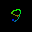

test_digit/6 expected, 6 found with score 0.988281


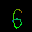

test_digit/6 expected, 6 found with score 0.992188


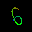

test_digit/6 expected, 6 found with score 0.906250


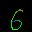

test_digit/6 expected, 6 found with score 0.976562


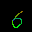

test_digit/6 expected, 6 found with score 0.972656


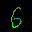

test_digit/6 expected, 6 found with score 0.984375


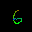

test_digit/6 expected, 6 found with score 0.972656


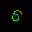

test_digit/6 expected, 6 found with score 0.996094


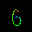

test_digit/6 expected, 6 found with score 0.988281


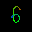

test_digit/6 expected, 6 found with score 0.980469


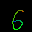

test_digit/6 expected, 6 found with score 0.992188


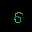

test_digit/6 expected, 6 found with score 0.988281


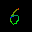

test_digit/6 expected, 6 found with score 0.980469


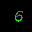

test_digit/6 expected, 6 found with score 0.953125


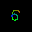

test_digit/6 expected, 6 found with score 0.832031


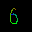

test_digit/6 expected, 6 found with score 0.980469


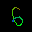

test_digit/6 expected, 6 found with score 0.960938


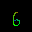

test_digit/6 expected, 6 found with score 0.992188


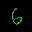

test_digit/6 expected, 6 found with score 0.835938


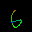

test_digit/6 expected, 6 found with score 0.976562


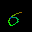

test_digit/6 expected, 6 found with score 0.988281


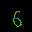

test_digit/6 expected, 6 found with score 0.968750


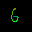

test_digit/6 expected, 6 found with score 0.984375


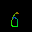

test_digit/6 expected, 6 found with score 0.968750


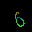

test_digit/6 expected, 6 found with score 0.980469


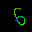

test_digit/6 expected, 6 found with score 0.968750


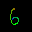

test_digit/6 expected, 6 found with score 0.964844


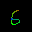

test_digit/6 expected, 6 found with score 0.984375


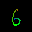

test_digit/6 expected, 6 found with score 0.964844


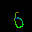

test_digit/6 expected, 6 found with score 0.996094


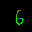

test_digit/6 expected, 6 found with score 0.925781


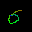

test_digit/6 expected, 6 found with score 0.976562


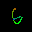

test_digit/6 expected, 6 found with score 0.957031


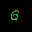

test_digit/6 expected, 6 found with score 0.945312


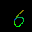

test_digit/6 expected, 6 found with score 0.964844


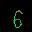

test_digit/6 expected, 6 found with score 0.988281


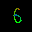

test_digit/6 expected, 6 found with score 0.972656


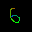

test_digit/6 expected, 6 found with score 0.996094


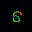

test_digit/6 expected, 6 found with score 0.996094


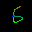

test_digit/6 expected, 6 found with score 0.992188


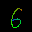

test_digit/6 expected, 6 found with score 0.914062


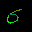

test_digit/6 expected, 6 found with score 0.980469


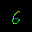

test_digit/6 expected, 6 found with score 0.898438


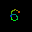

test_digit/6 expected, 6 found with score 0.968750


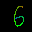

test_digit/6 expected, 6 found with score 0.984375


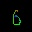

test_digit/6 expected, 6 found with score 0.988281


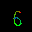

test_digit/6 expected, 6 found with score 0.988281


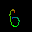

test_digit/6 expected, 6 found with score 0.996094


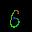

test_digit/6 expected, 6 found with score 0.984375


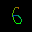

test_digit/6 expected, 6 found with score 0.980469


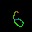

test_digit/6 expected, 6 found with score 0.976562


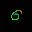

test_digit/6 expected, 6 found with score 0.992188


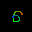

test_digit/6 expected, 6 found with score 0.992188


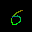

test_digit/6 expected, 6 found with score 0.941406


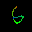

test_digit/6 expected, 6 found with score 0.925781


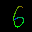

test_digit/6 expected, 6 found with score 0.945312


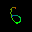

test_digit/6 expected, 6 found with score 0.992188


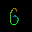

test_digit/6 expected, 6 found with score 0.937500


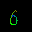

test_digit/6 expected, 6 found with score 0.996094


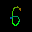

test_digit/6 expected, 6 found with score 0.953125


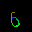

test_digit/6 expected, 6 found with score 0.992188


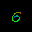

test_digit/6 expected, 6 found with score 0.996094


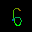

test_digit/6 expected, 6 found with score 0.992188


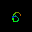

test_digit/6 expected, 6 found with score 0.976562


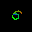

test_digit/6 expected, 6 found with score 0.941406


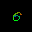

test_digit/6 expected, 6 found with score 0.902344


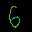

test_digit/6 expected, 6 found with score 0.960938


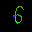

test_digit/6 expected, 6 found with score 0.980469


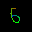

test_digit/6 expected, 6 found with score 0.972656


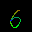

test_digit/6 expected, 6 found with score 0.992188


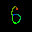

test_digit/6 expected, 6 found with score 0.988281


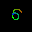

test_digit/6 expected, 6 found with score 0.972656


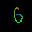

test_digit/6 expected, 6 found with score 0.964844


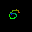

test_digit/6 expected, 6 found with score 0.957031


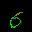

test_digit/6 expected, 6 found with score 0.992188


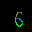

test_digit/6 expected, 6 found with score 0.976562


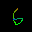

test_digit/6 expected, 6 found with score 0.957031


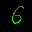

test_digit/6 expected, 6 found with score 0.992188


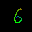

test_digit/6 expected, 6 found with score 0.945312


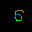

test_digit/6 expected, 6 found with score 0.960938


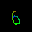

test_digit/6 expected, 6 found with score 0.976562


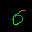

test_digit/6 expected, 6 found with score 0.992188


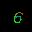

test_digit/6 expected, 6 found with score 0.984375


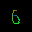

test_digit/6 expected, 6 found with score 0.945312


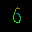

test_digit/6 expected, 6 found with score 0.941406


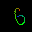

test_digit/6 expected, 6 found with score 0.984375


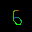

test_digit/6 expected, 6 found with score 0.988281


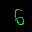

test_digit/6 expected, 6 found with score 0.953125


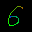

test_digit/6 expected, 6 found with score 0.984375


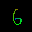

test_digit/6 expected, 6 found with score 0.937500


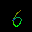

test_digit/6 expected, 6 found with score 0.992188


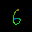

test_digit/6 expected, 6 found with score 0.996094


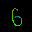

test_digit/6 expected, 6 found with score 0.886719


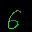

test_digit/6 expected, 6 found with score 0.968750


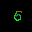

test_digit/6 expected, 6 found with score 0.980469


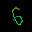

test_digit/6 expected, 6 found with score 0.976562


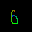

test_digit/6 expected, 6 found with score 0.972656


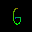

test_digit/6 expected, 6 found with score 0.992188


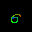

test_digit/6 expected, 6 found with score 0.910156


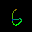

test_digit/6 expected, 6 found with score 0.976562


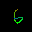

test_digit/6 expected, 6 found with score 0.984375


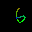

test_digit/6 expected, 6 found with score 0.976562


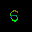

test_digit/6 expected, 6 found with score 0.980469


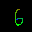

test_digit/6 expected, 6 found with score 0.980469


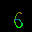

test_digit/6 expected, 6 found with score 0.996094


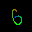

test_digit/6 expected, 6 found with score 0.996094


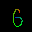

test_digit/6 expected, 6 found with score 0.996094


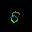

test_digit/6 expected, 6 found with score 0.976562


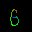

test_digit/6 expected, 6 found with score 0.964844


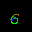

test_digit/4 expected, 4 found with score 0.988281


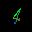

test_digit/4 expected, 4 found with score 0.968750


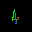

test_digit/4 expected, 4 found with score 0.972656


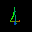

test_digit/4 expected, 4 found with score 0.921875


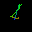

test_digit/4 expected, 4 found with score 0.976562


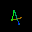

test_digit/4 expected, 4 found with score 0.996094


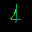

test_digit/4 expected, 4 found with score 0.996094


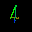

test_digit/4 expected, 4 found with score 0.980469


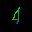

test_digit/4 expected, 4 found with score 0.992188


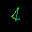

test_digit/4 expected, 4 found with score 0.980469


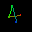

test_digit/4 expected, 4 found with score 0.996094


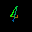

test_digit/4 expected, 4 found with score 0.996094


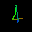

test_digit/4 expected, 4 found with score 0.996094


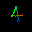

test_digit/4 expected, 4 found with score 0.968750


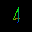

test_digit/4 expected, 4 found with score 0.996094


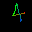

test_digit/4 expected, 4 found with score 0.929688


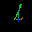

test_digit/4 expected, 4 found with score 0.988281


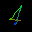

test_digit/4 expected, 4 found with score 0.988281


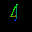

test_digit/4 expected, 4 found with score 0.996094


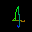

test_digit/4 expected, 4 found with score 0.996094


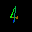

test_digit/4 expected, 4 found with score 0.996094


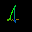

test_digit/4 expected, 4 found with score 0.988281


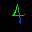

test_digit/4 expected, 4 found with score 0.964844


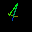

test_digit/4 expected, 4 found with score 0.871094


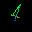

test_digit/4 expected, 4 found with score 0.996094


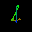

test_digit/4 expected, 4 found with score 0.996094


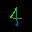

test_digit/4 expected, 4 found with score 0.976562


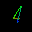

test_digit/4 expected, 4 found with score 0.996094


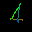

test_digit/4 expected, 4 found with score 0.996094


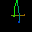

test_digit/4 expected, 4 found with score 0.988281


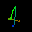

test_digit/4 expected, 4 found with score 0.996094


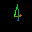

test_digit/4 expected, 4 found with score 0.996094


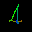

test_digit/4 expected, 4 found with score 0.957031


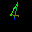

test_digit/4 expected, 4 found with score 0.996094


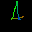

test_digit/4 expected, 4 found with score 0.992188


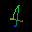

test_digit/4 expected, 4 found with score 0.996094


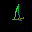

test_digit/4 expected, 4 found with score 0.933594


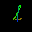

test_digit/4 expected, 4 found with score 0.984375


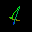

test_digit/4 expected, 4 found with score 0.996094


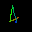

test_digit/4 expected, 4 found with score 0.855469


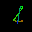

test_digit/4 expected, 4 found with score 0.992188


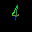

test_digit/4 expected, 4 found with score 0.996094


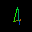

test_digit/4 expected, 4 found with score 0.996094


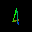

test_digit/4 expected, 4 found with score 0.992188


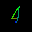

test_digit/4 expected, 4 found with score 0.988281


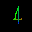

test_digit/4 expected, 4 found with score 0.988281


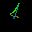

test_digit/4 expected, 4 found with score 0.847656


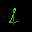

test_digit/4 expected, 4 found with score 0.996094


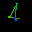

test_digit/4 expected, 4 found with score 0.957031


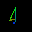

test_digit/4 expected, 4 found with score 0.996094


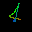

test_digit/4 expected, 4 found with score 0.992188


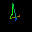

test_digit/4 expected, 4 found with score 0.996094


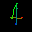

test_digit/4 expected, 4 found with score 0.925781


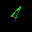

test_digit/4 expected, 4 found with score 0.914062


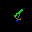

test_digit/4 expected, 4 found with score 0.988281


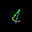

test_digit/4 expected, 4 found with score 0.996094


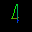

test_digit/4 expected, 4 found with score 0.984375


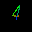

test_digit/4 expected, 4 found with score 0.988281


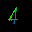

test_digit/4 expected, 4 found with score 0.960938


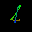

test_digit/4 expected, 4 found with score 0.945312


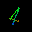

test_digit/4 expected, 4 found with score 0.996094


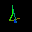

test_digit/4 expected, 4 found with score 0.996094


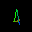

test_digit/4 expected, 4 found with score 0.988281


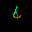

test_digit/4 expected, 4 found with score 0.996094


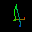

test_digit/4 expected, 4 found with score 0.992188


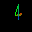

test_digit/4 expected, 4 found with score 0.988281


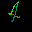

test_digit/4 expected, 4 found with score 0.996094


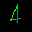

test_digit/4 expected, 4 found with score 0.996094


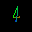

test_digit/4 expected, 4 found with score 0.988281


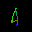

test_digit/4 expected, 4 found with score 0.996094


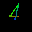

test_digit/4 expected, 4 found with score 0.996094


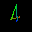

test_digit/4 expected, 4 found with score 0.996094


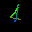

test_digit/4 expected, 4 found with score 0.968750


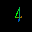

test_digit/4 expected, 4 found with score 0.988281


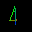

test_digit/4 expected, 4 found with score 0.980469


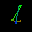

test_digit/4 expected, 4 found with score 0.968750


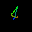

test_digit/4 expected, 4 found with score 0.769531


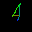

test_digit/4 expected, 4 found with score 0.996094


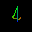

test_digit/4 expected, 4 found with score 0.992188


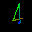

test_digit/4 expected, 4 found with score 0.847656


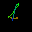

test_digit/4 expected, 4 found with score 0.972656


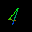

test_digit/4 expected, 4 found with score 0.996094


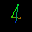

test_digit/4 expected, 4 found with score 0.996094


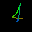

test_digit/4 expected, 4 found with score 0.996094


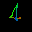

test_digit/4 expected, 4 found with score 0.910156


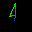

test_digit/4 expected, 4 found with score 0.996094


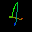

test_digit/4 expected, 4 found with score 0.839844


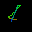

test_digit/4 expected, 4 found with score 0.996094


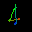

test_digit/4 expected, 4 found with score 0.996094


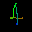

test_digit/4 expected, 4 found with score 0.992188


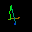

test_digit/4 expected, 4 found with score 0.996094


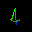

test_digit/4 expected, 4 found with score 0.996094


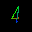

test_digit/4 expected, 4 found with score 0.988281


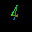

test_digit/4 expected, 4 found with score 0.988281


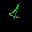

test_digit/4 expected, 4 found with score 0.917969


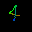

test_digit/4 expected, 4 found with score 0.996094


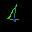

test_digit/4 expected, 4 found with score 0.996094


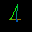

test_digit/4 expected, 4 found with score 0.960938


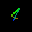

test_digit/4 expected, 4 found with score 0.972656


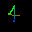

test_digit/4 expected, 4 found with score 0.984375


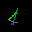

test_digit/4 expected, 4 found with score 0.996094


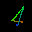

test_digit/4 expected, 4 found with score 0.972656


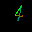

test_digit/4 expected, 4 found with score 0.972656


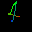

test_digit/4 expected, 4 found with score 0.996094


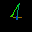

test_digit/4 expected, 4 found with score 0.992188


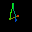

test_digit/4 expected, 4 found with score 0.996094


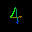

test_digit/4 expected, 4 found with score 0.957031


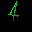

test_digit/4 expected, 4 found with score 0.960938


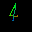

test_digit/4 expected, 4 found with score 0.968750


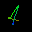

test_digit/4 expected, 4 found with score 0.929688


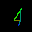

test_digit/4 expected, 4 found with score 0.976562


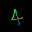

test_digit/4 expected, 4 found with score 0.996094


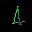

test_digit/4 expected, 4 found with score 0.988281


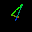

test_digit/4 expected, 4 found with score 0.984375


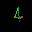

test_digit/4 expected, 4 found with score 0.949219


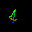

test_digit/4 expected, 4 found with score 0.996094


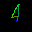

test_digit/4 expected, 4 found with score 0.875000


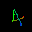

test_digit/4 expected, 4 found with score 0.980469


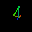

test_digit/4 expected, 4 found with score 0.996094


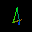

test_digit/1 expected, 1 found with score 0.996094


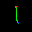

test_digit/1 expected, 1 found with score 0.988281


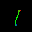

test_digit/1 expected, 1 found with score 0.992188


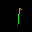

test_digit/1 expected, 1 found with score 0.996094


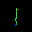

test_digit/1 expected, 1 found with score 0.988281


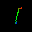

test_digit/1 expected, 1 found with score 0.988281


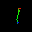

test_digit/1 expected, 1 found with score 0.996094


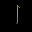

test_digit/1 expected, 1 found with score 0.996094


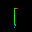

test_digit/1 expected, 1 found with score 0.890625


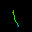

test_digit/1 expected, 1 found with score 0.902344


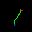

test_digit/1 expected, 1 found with score 0.988281


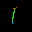

test_digit/1 expected, 1 found with score 0.972656


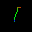

test_digit/1 expected, 1 found with score 0.996094


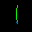

test_digit/1 expected, 1 found with score 0.996094


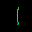

test_digit/1 expected, 1 found with score 0.980469


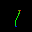

test_digit/1 expected, 1 found with score 0.968750


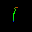

test_digit/1 expected, 1 found with score 0.992188


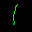

test_digit/1 expected, 1 found with score 0.910156


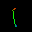

test_digit/1 expected, 1 found with score 0.976562


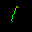

test_digit/1 expected, 1 found with score 0.996094


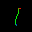

test_digit/1 expected, 1 found with score 0.980469


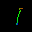

test_digit/1 expected, 1 found with score 0.992188


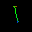

test_digit/1 expected, 1 found with score 0.996094


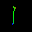

test_digit/1 expected, 1 found with score 0.996094


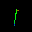

test_digit/1 expected, 1 found with score 0.996094


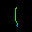

test_digit/1 expected, 1 found with score 0.996094


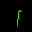

test_digit/1 expected, 1 found with score 0.996094


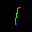

test_digit/1 expected, 1 found with score 0.996094


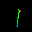

test_digit/1 expected, 1 found with score 0.996094


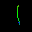

test_digit/1 expected, 1 found with score 0.980469


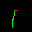

test_digit/1 expected, 1 found with score 0.910156


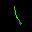

test_digit/1 expected, 1 found with score 0.996094


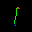

test_digit/1 expected, 1 found with score 0.992188


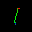

test_digit/1 expected, 1 found with score 0.976562


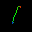

test_digit/1 expected, 1 found with score 0.921875


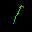

test_digit/1 expected, 1 found with score 0.996094


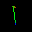

test_digit/1 expected, 1 found with score 0.988281


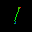

test_digit/1 expected, 1 found with score 0.992188


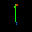

test_digit/1 expected, 1 found with score 0.992188


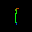

test_digit/1 expected, 1 found with score 0.996094


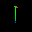

test_digit/1 expected, 1 found with score 0.996094


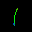

test_digit/1 expected, 1 found with score 0.996094


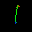

test_digit/1 expected, 1 found with score 0.976562


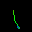

test_digit/1 expected, 1 found with score 0.996094


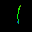

test_digit/1 expected, 1 found with score 0.992188


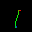

test_digit/1 expected, 1 found with score 0.996094


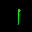

test_digit/1 expected, 1 found with score 0.992188


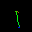

test_digit/1 expected, 1 found with score 0.996094


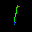

test_digit/1 expected, 1 found with score 0.949219


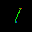

test_digit/1 expected, 1 found with score 0.996094


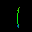

test_digit/1 expected, 1 found with score 0.972656


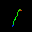

test_digit/1 expected, 1 found with score 0.996094


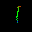

test_digit/1 expected, 1 found with score 0.996094


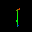

test_digit/1 expected, 1 found with score 0.988281


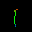

test_digit/1 expected, 1 found with score 0.996094


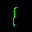

test_digit/0 expected, 0 found with score 0.996094


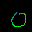

test_digit/0 expected, 0 found with score 0.933594


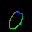

test_digit/0 expected, 0 found with score 0.996094


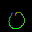

test_digit/0 expected, 0 found with score 0.933594


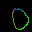

test_digit/0 expected, 0 found with score 0.988281


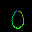

test_digit/0 expected, 0 found with score 0.988281


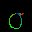

test_digit/0 expected, 0 found with score 0.996094


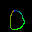

test_digit/0 expected, 0 found with score 0.980469


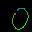

test_digit/0 expected, 0 found with score 0.980469


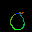

test_digit/0 expected, 0 found with score 0.992188


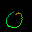

test_digit/0 expected, 0 found with score 0.992188


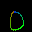

test_digit/0 expected, 0 found with score 0.941406


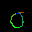

test_digit/0 expected, 0 found with score 0.996094


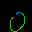

test_digit/0 expected, 0 found with score 0.800781


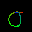

test_digit/0 expected, 0 found with score 0.984375


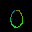

test_digit/0 expected, 0 found with score 0.941406


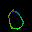

test_digit/0 expected, 0 found with score 0.996094


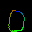

test_digit/0 expected, 0 found with score 0.992188


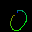

test_digit/0 expected, 0 found with score 0.804688


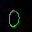

test_digit/0 expected, 0 found with score 0.996094


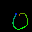

test_digit/0 expected, 0 found with score 0.996094


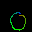

test_digit/0 expected, 0 found with score 0.890625


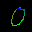

test_digit/0 expected, 0 found with score 0.902344


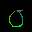

test_digit/0 expected, 0 found with score 0.929688


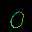

test_digit/0 expected, 0 found with score 0.882812


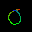

test_digit/0 expected, 0 found with score 0.992188


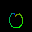

test_digit/0 expected, 0 found with score 0.996094


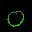

test_digit/0 expected, 0 found with score 0.996094


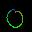

test_digit/0 expected, 0 found with score 0.976562


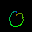

test_digit/0 expected, 0 found with score 0.941406


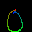

test_digit/0 expected, 0 found with score 0.882812


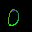

test_digit/0 expected, 0 found with score 0.968750


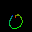

test_digit/0 expected, 0 found with score 0.968750


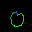

test_digit/0 expected, 0 found with score 0.992188


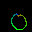

test_digit/0 expected, 0 found with score 0.886719


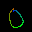

test_digit/0 expected, 0 found with score 0.996094


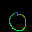

test_digit/0 expected, 0 found with score 0.859375


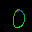

test_digit/0 expected, 0 found with score 0.890625


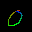

test_digit/0 expected, 0 found with score 0.992188


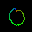

test_digit/0 expected, 0 found with score 0.980469


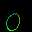

test_digit/0 expected, 0 found with score 0.996094


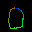

test_digit/0 expected, 0 found with score 0.996094


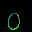

test_digit/0 expected, 0 found with score 0.980469


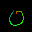

test_digit/0 expected, 0 found with score 0.976562


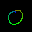

test_digit/0 expected, 0 found with score 0.988281


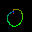

test_digit/0 expected, 0 found with score 0.996094


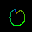

test_digit/0 expected, 0 found with score 0.992188


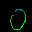

test_digit/0 expected, 0 found with score 0.789062


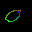

test_digit/0 expected, 0 found with score 0.976562


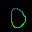

test_digit/0 expected, 0 found with score 0.980469


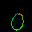

test_digit/0 expected, 0 found with score 0.996094


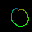

test_digit/0 expected, 0 found with score 0.996094


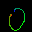

test_digit/0 expected, 0 found with score 0.929688


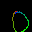

test_digit/0 expected, 0 found with score 0.992188


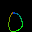

test_digit/0 expected, 0 found with score 0.925781


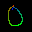

test_digit/0 expected, 0 found with score 0.992188


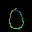

test_digit/0 expected, 0 found with score 0.886719


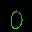

test_digit/0 expected, 0 found with score 0.992188


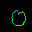

test_digit/0 expected, 0 found with score 0.988281


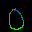

test_digit/0 expected, 0 found with score 0.953125


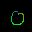

test_digit/0 expected, 0 found with score 0.996094


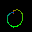

test_digit/0 expected, 0 found with score 0.914062


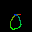

test_digit/0 expected, 0 found with score 0.972656


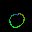

test_digit/0 expected, 0 found with score 0.996094


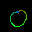

test_digit/0 expected, 0 found with score 0.976562


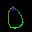

test_digit/0 expected, 0 found with score 0.992188


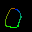

test_digit/0 expected, 0 found with score 0.996094


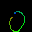

test_digit/0 expected, 0 found with score 0.980469


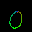

test_digit/0 expected, 0 found with score 0.984375


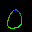

test_digit/0 expected, 0 found with score 0.992188


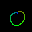

test_digit/0 expected, 0 found with score 0.820312


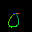

test_digit/0 expected, 0 found with score 0.937500


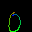

test_digit/0 expected, 0 found with score 0.996094


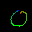

test_digit/0 expected, 0 found with score 0.957031


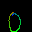

test_digit/0 expected, 0 found with score 0.996094


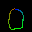

test_digit/0 expected, 0 found with score 0.992188


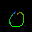

test_digit/0 expected, 0 found with score 0.988281


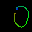

test_digit/0 expected, 0 found with score 0.996094


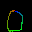

test_digit/0 expected, 0 found with score 0.996094


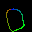

test_digit/0 expected, 0 found with score 0.984375


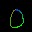

test_digit/0 expected, 0 found with score 0.980469


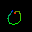

test_digit/0 expected, 0 found with score 0.988281


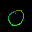

test_digit/0 expected, 0 found with score 0.992188


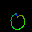

test_digit/0 expected, 0 found with score 0.968750


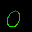

test_digit/0 expected, 0 found with score 0.750000


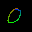

test_digit/0 expected, 0 found with score 0.992188


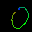

test_digit/0 expected, 0 found with score 0.921875


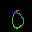

test_digit/0 expected, 0 found with score 0.996094


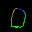

test_digit/0 expected, 0 found with score 0.984375


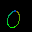

test_digit/0 expected, 0 found with score 0.984375


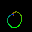

test_digit/0 expected, 8 found with score 0.757812


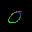

test_digit/0 expected, 0 found with score 0.996094


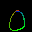

test_digit/0 expected, 0 found with score 0.996094


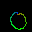

test_digit/0 expected, 0 found with score 0.992188


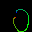

test_digit/0 expected, 0 found with score 0.804688


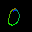

test_digit/0 expected, 0 found with score 0.992188


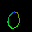

test_digit/0 expected, 0 found with score 0.992188


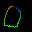

test_digit/0 expected, 0 found with score 0.992188


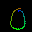

test_digit/0 expected, 0 found with score 0.925781


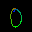

test_digit/0 expected, 0 found with score 0.984375


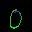

test_digit/0 expected, 0 found with score 0.867188


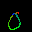

test_digit/0 expected, 0 found with score 0.765625


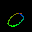

test_digit/0 expected, 0 found with score 0.992188


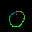

test_digit/0 expected, 0 found with score 0.937500


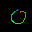

test_digit/0 expected, 0 found with score 0.968750


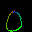

test_digit/0 expected, 0 found with score 0.996094


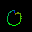

test_digit/0 expected, 0 found with score 0.929688


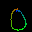

test_digit/0 expected, 0 found with score 0.972656


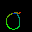

test_digit/0 expected, 0 found with score 0.964844


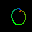

test_digit/0 expected, 0 found with score 0.917969


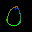

test_digit/0 expected, 0 found with score 0.992188


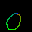

test_digit/0 expected, 0 found with score 0.988281


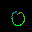

test_digit/0 expected, 0 found with score 0.996094


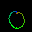

test_digit/0 expected, 0 found with score 0.945312


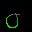

test_digit/0 expected, 0 found with score 0.992188


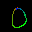

test_digit/0 expected, 0 found with score 0.996094


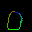

test_digit/0 expected, 0 found with score 0.945312


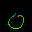

test_digit/0 expected, 0 found with score 0.953125


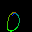

test_digit/0 expected, 0 found with score 0.996094


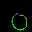

test_digit/0 expected, 0 found with score 0.992188


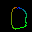

test_digit/0 expected, 0 found with score 0.882812


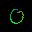

test_digit/0 expected, 0 found with score 0.984375


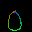

test_digit/0 expected, 0 found with score 0.957031


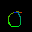

test_digit/0 expected, 0 found with score 0.964844


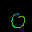

test_digit/0 expected, 0 found with score 0.984375


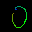

test_digit/0 expected, 0 found with score 0.925781


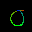

test_digit/0 expected, 0 found with score 0.996094


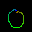

test_digit/0 expected, 0 found with score 0.988281


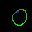

test_digit/0 expected, 0 found with score 0.898438


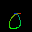

test_digit/0 expected, 0 found with score 0.996094


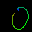

test_digit/0 expected, 0 found with score 0.917969


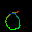

test_digit/0 expected, 0 found with score 0.996094


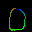

test_digit/8 expected, 8 found with score 0.992188


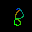

test_digit/8 expected, 8 found with score 0.996094


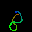

test_digit/8 expected, 8 found with score 0.980469


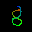

test_digit/8 expected, 8 found with score 0.996094


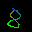

test_digit/8 expected, 8 found with score 0.980469


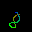

test_digit/8 expected, 8 found with score 0.988281


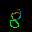

test_digit/8 expected, 8 found with score 0.996094


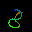

test_digit/8 expected, 8 found with score 0.972656


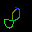

test_digit/8 expected, 8 found with score 0.957031


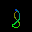

test_digit/8 expected, 8 found with score 0.984375


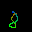

test_digit/8 expected, 8 found with score 0.996094


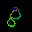

test_digit/8 expected, 8 found with score 0.964844


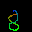

test_digit/8 expected, 8 found with score 0.992188


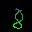

test_digit/8 expected, 8 found with score 0.988281


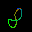

test_digit/8 expected, 8 found with score 0.972656


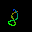

test_digit/8 expected, 8 found with score 0.992188


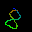

test_digit/8 expected, 8 found with score 0.996094


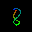

test_digit/8 expected, 8 found with score 0.910156


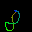

test_digit/8 expected, 8 found with score 0.968750


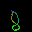

test_digit/8 expected, 8 found with score 0.996094


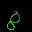

test_digit/8 expected, 8 found with score 0.812500


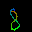

test_digit/8 expected, 8 found with score 0.992188


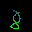

test_digit/8 expected, 8 found with score 0.968750


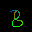

test_digit/8 expected, 8 found with score 0.992188


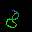

test_digit/8 expected, 8 found with score 0.976562


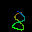

test_digit/8 expected, 8 found with score 0.949219


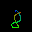

test_digit/8 expected, 8 found with score 0.988281


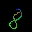

test_digit/8 expected, 8 found with score 0.906250


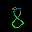

test_digit/8 expected, 8 found with score 0.988281


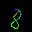

test_digit/8 expected, 8 found with score 0.968750


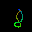

test_digit/8 expected, 8 found with score 0.992188


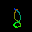

test_digit/8 expected, 8 found with score 0.988281


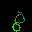

test_digit/8 expected, 8 found with score 0.964844


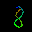

test_digit/8 expected, 8 found with score 0.992188


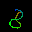

test_digit/8 expected, 8 found with score 0.984375


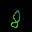

test_digit/8 expected, 8 found with score 0.886719


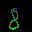

test_digit/8 expected, 8 found with score 0.984375


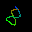

test_digit/8 expected, 8 found with score 0.992188


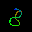

test_digit/8 expected, 8 found with score 0.996094


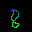

test_digit/8 expected, 8 found with score 0.988281


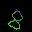

test_digit/8 expected, 8 found with score 0.996094


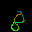

test_digit/8 expected, 8 found with score 0.968750


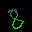

test_digit/8 expected, 8 found with score 0.968750


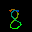

test_digit/8 expected, 8 found with score 0.941406


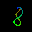

test_digit/8 expected, 8 found with score 0.992188


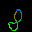

test_digit/8 expected, 8 found with score 0.929688


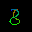

test_digit/8 expected, 8 found with score 0.976562


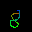

test_digit/8 expected, 8 found with score 0.917969


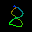

test_digit/8 expected, 8 found with score 0.945312


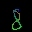

test_digit/8 expected, 8 found with score 0.953125


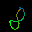

test_digit/8 expected, 8 found with score 0.808594


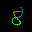

test_digit/8 expected, 8 found with score 0.957031


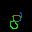

test_digit/8 expected, 8 found with score 0.964844


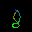

test_digit/8 expected, 8 found with score 0.992188


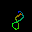

test_digit/8 expected, 8 found with score 0.984375


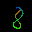

test_digit/8 expected, 8 found with score 0.886719


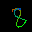

test_digit/8 expected, 8 found with score 0.964844


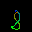

test_digit/8 expected, 8 found with score 0.996094


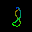

test_digit/8 expected, 8 found with score 0.820312


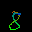

test_digit/8 expected, 8 found with score 0.992188


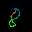

test_digit/8 expected, 8 found with score 0.972656


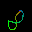

test_digit/8 expected, 8 found with score 0.992188


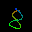

test_digit/8 expected, 8 found with score 0.914062


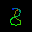

test_digit/8 expected, 8 found with score 0.960938


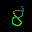

test_digit/8 expected, 8 found with score 0.843750


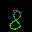

test_digit/8 expected, 8 found with score 0.992188


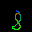

test_digit/8 expected, 8 found with score 0.917969


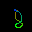

test_digit/8 expected, 8 found with score 0.925781


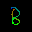

test_digit/8 expected, 8 found with score 0.980469


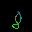

test_digit/8 expected, 8 found with score 0.996094


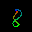

test_digit/8 expected, 8 found with score 0.992188


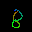

test_digit/8 expected, 8 found with score 0.957031


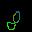

test_digit/8 expected, 8 found with score 0.992188


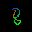

test_digit/8 expected, 8 found with score 0.996094


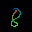

test_digit/8 expected, 8 found with score 0.925781


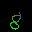

test_digit/8 expected, 8 found with score 0.992188


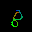

test_digit/8 expected, 8 found with score 0.960938


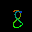

test_digit/8 expected, 8 found with score 0.992188


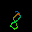

test_digit/8 expected, 8 found with score 0.968750


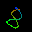

test_digit/8 expected, 8 found with score 0.972656


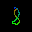

test_digit/8 expected, 8 found with score 0.992188


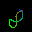

test_digit/8 expected, 8 found with score 0.992188


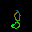

test_digit/8 expected, 8 found with score 0.980469


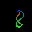

test_digit/8 expected, 8 found with score 0.988281


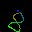

test_digit/8 expected, 8 found with score 0.847656


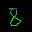

test_digit/8 expected, 8 found with score 0.988281


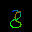

test_digit/8 expected, 8 found with score 0.953125


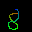

test_digit/8 expected, 8 found with score 0.882812


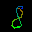

test_digit/8 expected, 8 found with score 0.878906


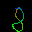

test_digit/8 expected, 8 found with score 0.992188


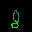

test_digit/8 expected, 8 found with score 0.988281


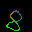

test_digit/8 expected, 8 found with score 0.960938


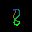

test_digit/8 expected, 8 found with score 0.988281


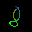

test_digit/8 expected, 8 found with score 0.996094


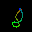

test_digit/8 expected, 8 found with score 0.964844


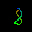

test_digit/8 expected, 8 found with score 0.933594


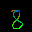

test_digit/8 expected, 8 found with score 0.996094


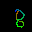

test_digit/8 expected, 8 found with score 0.972656


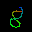

test_digit/8 expected, 8 found with score 0.988281


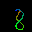

test_digit/8 expected, 8 found with score 0.984375


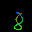

test_digit/8 expected, 8 found with score 0.882812


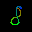

test_digit/8 expected, 8 found with score 0.996094


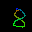

test_digit/8 expected, 8 found with score 0.980469


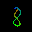

test_digit/8 expected, 8 found with score 0.945312


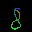

test_digit/8 expected, 8 found with score 0.980469


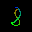

test_digit/8 expected, 8 found with score 0.984375


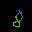

test_digit/8 expected, 8 found with score 0.964844


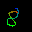

test_digit/8 expected, 8 found with score 0.988281


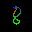

test_digit/8 expected, 8 found with score 0.992188


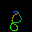

test_digit/8 expected, 8 found with score 0.988281


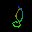

test_digit/8 expected, 8 found with score 0.992188


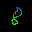

test_digit/8 expected, 8 found with score 0.996094


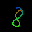

test_digit/8 expected, 8 found with score 0.996094


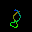

test_digit/8 expected, 8 found with score 0.890625


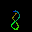

test_digit/8 expected, 8 found with score 0.980469


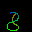

test_digit/8 expected, 8 found with score 0.992188


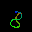

test_digit/8 expected, 8 found with score 0.976562


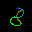

test_digit/8 expected, 8 found with score 0.953125


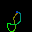

test_digit/8 expected, 8 found with score 0.984375


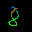

test_digit/8 expected, 8 found with score 0.957031


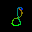

test_digit/8 expected, 8 found with score 0.917969


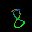

test_digit/8 expected, 8 found with score 0.988281


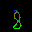

test_digit/8 expected, 8 found with score 0.910156


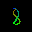

test_digit/8 expected, 8 found with score 0.988281


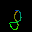

test_digit/8 expected, 8 found with score 0.988281


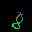

test_digit/8 expected, 8 found with score 0.976562


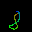

test_digit/8 expected, 8 found with score 0.996094


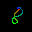

test_digit/2 expected, 2 found with score 0.964844


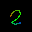

test_digit/2 expected, 2 found with score 0.976562


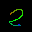

test_digit/2 expected, 2 found with score 0.972656


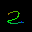

test_digit/2 expected, 2 found with score 0.960938


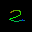

test_digit/2 expected, 2 found with score 0.839844


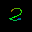

test_digit/2 expected, 2 found with score 0.964844


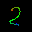

test_digit/2 expected, 2 found with score 0.988281


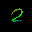

test_digit/2 expected, 2 found with score 0.984375


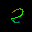

test_digit/2 expected, 2 found with score 0.957031


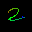

test_digit/2 expected, 2 found with score 0.984375


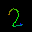

test_digit/2 expected, 2 found with score 0.992188


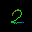

test_digit/2 expected, 2 found with score 0.972656


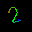

test_digit/2 expected, 2 found with score 0.906250


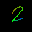

test_digit/2 expected, 2 found with score 0.972656


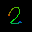

test_digit/2 expected, 2 found with score 0.917969


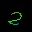

test_digit/2 expected, 2 found with score 0.988281


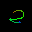

test_digit/2 expected, 2 found with score 0.980469


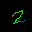

test_digit/2 expected, 2 found with score 0.933594


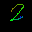

test_digit/2 expected, 2 found with score 0.984375


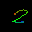

test_digit/2 expected, 2 found with score 0.968750


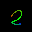

test_digit/2 expected, 2 found with score 0.957031


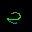

test_digit/2 expected, 2 found with score 0.964844


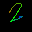

test_digit/2 expected, 2 found with score 0.980469


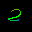

test_digit/2 expected, 2 found with score 0.968750


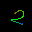

test_digit/2 expected, 2 found with score 0.980469


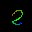

test_digit/2 expected, 2 found with score 0.976562


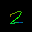

test_digit/2 expected, 2 found with score 0.964844


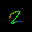

test_digit/2 expected, 2 found with score 0.984375


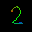

test_digit/2 expected, 2 found with score 0.968750


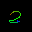

test_digit/2 expected, 2 found with score 0.992188


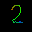

test_digit/2 expected, 2 found with score 0.917969


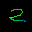

test_digit/2 expected, 2 found with score 0.898438


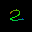

test_digit/2 expected, 2 found with score 0.968750


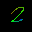

test_digit/2 expected, 2 found with score 0.843750


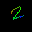

test_digit/2 expected, 2 found with score 0.992188


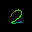

test_digit/2 expected, 2 found with score 0.917969


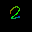

test_digit/2 expected, 2 found with score 0.996094


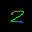

test_digit/2 expected, 2 found with score 0.949219


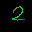

test_digit/2 expected, 2 found with score 0.957031


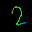

test_digit/2 expected, 2 found with score 0.988281


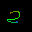

test_digit/2 expected, 2 found with score 0.882812


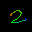

test_digit/2 expected, 2 found with score 0.933594


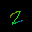

test_digit/2 expected, 2 found with score 0.933594


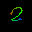

test_digit/2 expected, 2 found with score 0.972656


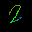

test_digit/2 expected, 2 found with score 0.933594


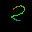

test_digit/2 expected, 2 found with score 0.988281


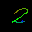

test_digit/2 expected, 2 found with score 0.996094


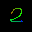

test_digit/2 expected, 2 found with score 0.984375


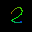

test_digit/2 expected, 2 found with score 0.980469


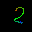

test_digit/2 expected, 2 found with score 0.992188


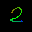

test_digit/2 expected, 2 found with score 0.933594


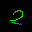

test_digit/2 expected, 2 found with score 0.929688


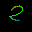

test_digit/2 expected, 2 found with score 0.824219


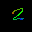

test_digit/2 expected, 2 found with score 0.988281


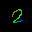

test_digit/2 expected, 2 found with score 0.992188


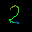

test_digit/2 expected, 2 found with score 0.988281


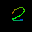

test_digit/2 expected, 2 found with score 0.988281


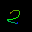

test_digit/2 expected, 2 found with score 0.929688


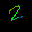

test_digit/2 expected, 2 found with score 0.972656


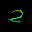

test_digit/2 expected, 2 found with score 0.917969


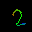

test_digit/2 expected, 2 found with score 0.886719


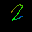

test_digit/2 expected, 2 found with score 0.980469


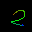

test_digit/2 expected, 2 found with score 0.953125


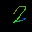

test_digit/2 expected, 2 found with score 0.988281


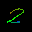

test_digit/2 expected, 2 found with score 0.988281


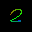

test_digit/2 expected, 2 found with score 0.980469


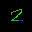

test_digit/2 expected, 2 found with score 0.968750


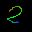

test_digit/2 expected, 2 found with score 0.964844


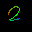

test_digit/2 expected, 2 found with score 0.945312


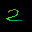

test_digit/2 expected, 2 found with score 0.890625


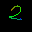

test_digit/2 expected, 2 found with score 0.949219


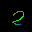

test_digit/2 expected, 2 found with score 0.949219


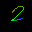

test_digit/2 expected, 2 found with score 0.964844


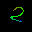

test_digit/2 expected, 2 found with score 0.964844


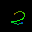

test_digit/2 expected, 2 found with score 0.968750


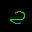

test_digit/2 expected, 2 found with score 0.984375


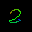

test_digit/2 expected, 2 found with score 0.945312


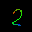

test_digit/2 expected, 2 found with score 0.820312


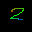

test_digit/2 expected, 2 found with score 0.960938


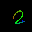

test_digit/2 expected, 2 found with score 0.992188


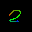

test_digit/2 expected, 2 found with score 0.980469


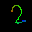

test_digit/2 expected, 2 found with score 0.992188


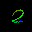

test_digit/2 expected, 2 found with score 0.960938


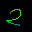

test_figure/circle expected, 0 found with score 0.996094


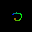

test_figure/circle expected, 0 found with score 0.996094


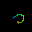

test_figure/circle expected, 0 found with score 0.996094


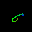

test_figure/circle expected, 0 found with score 0.996094


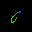

test_figure/circle expected, 0 found with score 0.996094


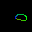

test_figure/circle expected, 0 found with score 0.996094


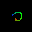

test_figure/circle expected, 0 found with score 0.996094


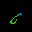

test_figure/circle expected, 0 found with score 0.996094


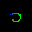

test_figure/circle expected, 0 found with score 0.996094


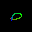

test_figure/circle expected, 0 found with score 0.996094


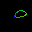

test_figure/circle expected, 0 found with score 0.996094


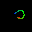

test_figure/circle expected, 0 found with score 0.996094


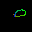

test_figure/circle expected, 0 found with score 0.996094


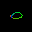

test_figure/circle expected, 0 found with score 0.996094


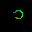

test_figure/circle expected, 0 found with score 0.996094


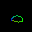

test_figure/circle expected, 0 found with score 0.996094


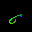

test_figure/circle expected, 0 found with score 0.996094


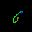

test_figure/circle expected, 0 found with score 0.996094


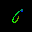

test_figure/circle expected, 0 found with score 0.996094


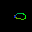

test_figure/circle expected, 0 found with score 0.996094


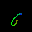

test_figure/circle expected, 0 found with score 0.996094


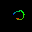

test_figure/circle expected, 0 found with score 0.996094


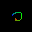

test_figure/circle expected, 0 found with score 0.996094


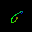

test_figure/circle expected, 0 found with score 0.996094


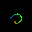

test_figure/circle expected, 0 found with score 0.996094


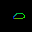

test_figure/circle expected, 0 found with score 0.996094


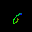

test_figure/circle expected, 0 found with score 0.996094


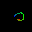

test_figure/circle expected, 0 found with score 0.996094


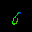

test_figure/circle expected, 0 found with score 0.996094


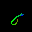

test_figure/circle expected, 0 found with score 0.996094


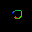

test_figure/circle expected, 0 found with score 0.996094


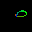

test_figure/circle expected, 0 found with score 0.996094


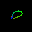

test_figure/circle expected, 0 found with score 0.996094


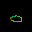

test_figure/heart expected, 1 found with score 0.992188


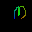

test_figure/heart expected, 0 found with score 0.945312


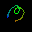

test_figure/heart expected, 1 found with score 0.988281


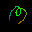

test_figure/heart expected, 0 found with score 0.777344


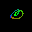

test_figure/heart expected, 0 found with score 0.757812


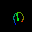

test_figure/heart expected, 1 found with score 0.949219


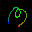

test_figure/heart expected, 1 found with score 0.867188


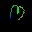

test_figure/heart expected, 0 found with score 0.886719


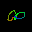

test_figure/heart expected, 1 found with score 0.968750


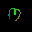

test_figure/heart expected, 0 found with score 0.972656


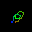

test_figure/heart expected, 1 found with score 0.843750


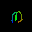

test_figure/heart expected, 1 found with score 0.980469


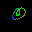

test_figure/heart expected, 0 found with score 0.859375


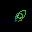

test_figure/heart expected, 1 found with score 0.964844


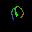

test_figure/heart expected, 1 found with score 0.964844


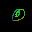

test_figure/heart expected, 1 found with score 0.984375


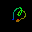

test_figure/heart expected, 1 found with score 0.996094


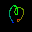

test_figure/heart expected, 1 found with score 0.972656


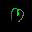

test_figure/heart expected, 1 found with score 0.890625


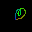

test_figure/heart expected, 1 found with score 0.992188


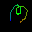

test_figure/heart expected, 1 found with score 0.753906


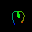

test_figure/heart expected, 1 found with score 0.992188


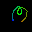

test_figure/heart expected, 1 found with score 0.996094


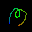

test_figure/heart expected, 1 found with score 0.925781


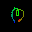

test_figure/heart expected, 0 found with score 0.792969


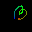

test_figure/heart expected, 1 found with score 0.949219


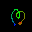

test_figure/heart expected, 1 found with score 0.984375


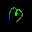

test_figure/heart expected, 1 found with score 0.796875


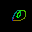

test_figure/heart expected, 1 found with score 0.937500


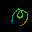

test_figure/heart expected, 1 found with score 0.933594


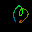

test_figure/heart expected, 0 found with score 0.757812


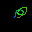

test_figure/heart expected, 1 found with score 0.996094


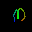

test_figure/heart expected, 1 found with score 0.824219


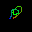

test_figure/heart expected, 1 found with score 0.878906


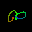

test_figure/heart expected, 1 found with score 0.925781


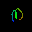

test_figure/heart expected, 1 found with score 0.921875


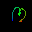

test_figure/heart expected, 0 found with score 0.765625


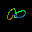

test_figure/heart expected, 1 found with score 0.953125


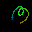

test_figure/heart expected, 1 found with score 0.847656


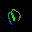

test_figure/heart expected, 1 found with score 0.941406


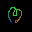

test_figure/heart expected, 1 found with score 0.980469


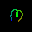

test_figure/heart expected, 1 found with score 0.976562


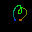

test_figure/heart expected, 1 found with score 0.828125


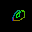

test_figure/heart expected, 1 found with score 0.843750


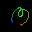

test_figure/heart expected, 1 found with score 0.937500


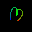

test_figure/heart expected, 1 found with score 0.812500


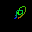

test_figure/heart expected, 1 found with score 0.765625


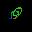

test_figure/heart expected, 1 found with score 0.953125


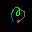

test_figure/heart expected, 1 found with score 0.972656


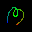

test_figure/heart expected, 1 found with score 0.996094


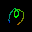

test_figure/heart expected, 0 found with score 0.972656


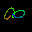

test_figure/heart expected, 1 found with score 0.957031


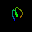

test_figure/heart expected, 1 found with score 0.828125


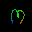

test_figure/heart expected, 1 found with score 0.996094


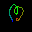

test_figure/heart expected, 1 found with score 0.933594


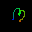

test_figure/heart expected, 0 found with score 0.785156


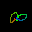

test_figure/star expected, 2 found with score 0.988281


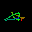

test_figure/star expected, 2 found with score 0.976562


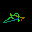

test_figure/star expected, 2 found with score 0.996094


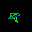

test_figure/star expected, 2 found with score 0.996094


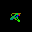

test_figure/star expected, 2 found with score 0.996094


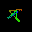

test_figure/star expected, 2 found with score 0.972656


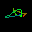

test_figure/star expected, 2 found with score 0.996094


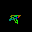

test_figure/star expected, 2 found with score 0.996094


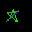

test_figure/star expected, 2 found with score 0.964844


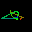

test_figure/star expected, 2 found with score 0.996094


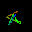

test_figure/star expected, 2 found with score 0.996094


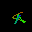

test_figure/star expected, 2 found with score 0.996094


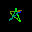

test_figure/star expected, 2 found with score 0.996094


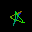

test_figure/star expected, 2 found with score 0.968750


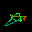

test_figure/star expected, 2 found with score 0.996094


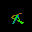

test_figure/star expected, 2 found with score 0.992188


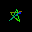

test_figure/star expected, 2 found with score 0.996094


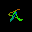

test_figure/star expected, 2 found with score 0.996094


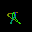

test_figure/star expected, 2 found with score 0.996094


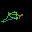

test_figure/star expected, 2 found with score 0.996094


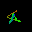

test_figure/star expected, 2 found with score 0.996094


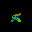

test_figure/star expected, 2 found with score 0.996094


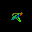

test_figure/star expected, 2 found with score 0.984375


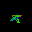

test_figure/star expected, 2 found with score 0.996094


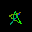

test_figure/star expected, 2 found with score 0.988281


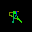

test_figure/star expected, 2 found with score 0.996094


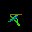

test_figure/star expected, 2 found with score 0.996094


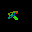

test_figure/star expected, 2 found with score 0.996094


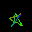

test_figure/star expected, 2 found with score 0.792969


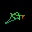

test_figure/star expected, 2 found with score 0.996094


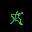

test_figure/star expected, 2 found with score 0.996094


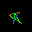

test_figure/star expected, 2 found with score 0.988281


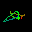

test_figure/star expected, 2 found with score 0.976562


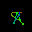

test_figure/star expected, 2 found with score 0.984375


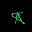

test_figure/star expected, 2 found with score 0.996094


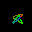

test_figure/star expected, 2 found with score 0.972656


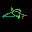

test_figure/star expected, 2 found with score 0.996094


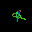

test_figure/star expected, 2 found with score 0.996094


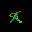

test_figure/star expected, 2 found with score 0.996094


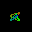

test_figure/star expected, 2 found with score 0.996094


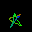

test_figure/star expected, 2 found with score 0.996094


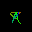

test_figure/star expected, 2 found with score 0.996094


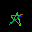

test_figure/star expected, 2 found with score 0.976562


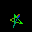

test_figure/star expected, 2 found with score 0.972656


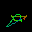

test_figure/star expected, 2 found with score 0.996094


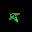

test_figure/star expected, 2 found with score 0.996094


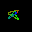

test_figure/star expected, 2 found with score 0.976562


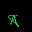

test_figure/star expected, 2 found with score 0.953125


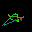

test_figure/star expected, 2 found with score 0.996094


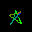

test_figure/star expected, 2 found with score 0.980469


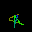

test_figure/star expected, 2 found with score 0.996094


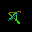

test_figure/star expected, 2 found with score 0.996094


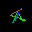

test_figure/star expected, 2 found with score 0.996094


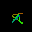

test_figure/star expected, 2 found with score 0.996094


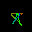

test_alphabet/b expected, 0 found with score 0.992188


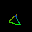

test_alphabet/b expected, 0 found with score 0.996094


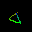

test_alphabet/b expected, 0 found with score 0.996094


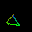

test_alphabet/b expected, 0 found with score 0.996094


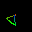

test_alphabet/b expected, 0 found with score 0.992188


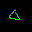

test_alphabet/b expected, 0 found with score 0.988281


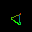

test_alphabet/b expected, 0 found with score 0.996094


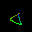

test_alphabet/b expected, 0 found with score 0.960938


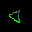

test_alphabet/b expected, 0 found with score 0.992188


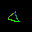

test_alphabet/b expected, 0 found with score 0.898438


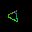

test_alphabet/b expected, 0 found with score 0.750000


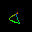

test_alphabet/a expected, 0 found with score 0.996094


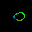

test_alphabet/a expected, 0 found with score 0.996094


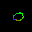

test_alphabet/a expected, 0 found with score 0.996094


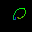

test_alphabet/a expected, 0 found with score 0.996094


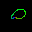

test_alphabet/a expected, 0 found with score 0.996094


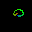

test_alphabet/a expected, 0 found with score 0.996094


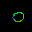

test_alphabet/a expected, 0 found with score 0.996094


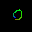

test_alphabet/a expected, 0 found with score 0.996094


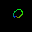

test_alphabet/a expected, 0 found with score 0.996094


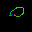

test_alphabet/a expected, 0 found with score 0.996094


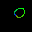

test_alphabet/a expected, 0 found with score 0.996094


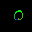

test_alphabet/a expected, 0 found with score 0.996094


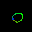

test_alphabet/a expected, 0 found with score 0.996094


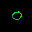

test_alphabet/a expected, 0 found with score 0.996094


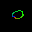

test_alphabet/a expected, 0 found with score 0.996094


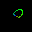

test_alphabet/a expected, 0 found with score 0.996094


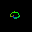

test_alphabet/a expected, 0 found with score 0.996094


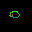

test_alphabet/a expected, 0 found with score 0.996094


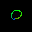

test_alphabet/a expected, 0 found with score 0.996094


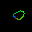

test_alphabet/a expected, 0 found with score 0.996094


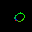

test_alphabet/a expected, 0 found with score 0.996094


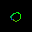

test_alphabet/a expected, 0 found with score 0.996094


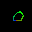

test_alphabet/a expected, 0 found with score 0.996094


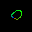

test_alphabet/a expected, 0 found with score 0.996094


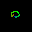

test_alphabet/a expected, 0 found with score 0.996094


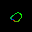

test_alphabet/a expected, 0 found with score 0.996094


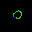

test_alphabet/a expected, 0 found with score 0.996094


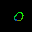

test_alphabet/a expected, 0 found with score 0.996094


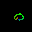

test_alphabet/a expected, 0 found with score 0.996094


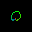

test_alphabet/a expected, 0 found with score 0.996094


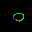

test_alphabet/a expected, 0 found with score 0.996094


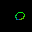

test_alphabet/a expected, 0 found with score 0.996094


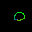

test_alphabet/a expected, 0 found with score 0.996094


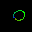

test_alphabet/a expected, 0 found with score 0.996094


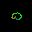

test_alphabet/a expected, 0 found with score 0.996094


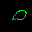

test_alphabet/a expected, 0 found with score 0.996094


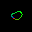

test_alphabet/a expected, 0 found with score 0.996094


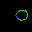

test_alphabet/a expected, 0 found with score 0.996094


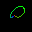

test_alphabet/a expected, 0 found with score 0.996094


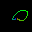

test_alphabet/a expected, 0 found with score 0.996094


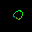

test_alphabet/a expected, 0 found with score 0.996094


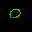

test_alphabet/a expected, 0 found with score 0.996094


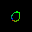

test_alphabet/a expected, 0 found with score 0.996094


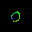

test_alphabet/a expected, 0 found with score 0.996094


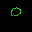

test_alphabet/a expected, 0 found with score 0.996094


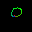

test_alphabet/a expected, 0 found with score 0.996094


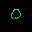

test_alphabet/a expected, 0 found with score 0.996094


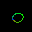

test_alphabet/a expected, 0 found with score 0.996094


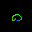

test_alphabet/a expected, 0 found with score 0.996094


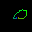

test_alphabet/a expected, 0 found with score 0.996094


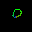

test_alphabet/a expected, 0 found with score 0.996094


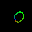

test_alphabet/a expected, 0 found with score 0.996094


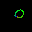

test_alphabet/a expected, 0 found with score 0.996094


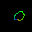

test_alphabet/a expected, 0 found with score 0.996094


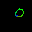

test_alphabet/a expected, 0 found with score 0.996094


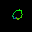

test_alphabet/a expected, 0 found with score 0.996094


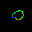

test_alphabet/a expected, 0 found with score 0.996094


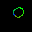

test_alphabet/a expected, 0 found with score 0.996094


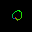

test_alphabet/a expected, 0 found with score 0.996094


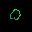

test_alphabet/a expected, 0 found with score 0.996094


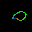

test_alphabet/a expected, 0 found with score 0.996094


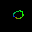

test_alphabet/a expected, 0 found with score 0.996094


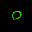

test_alphabet/a expected, 0 found with score 0.996094


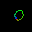

test_alphabet/a expected, 0 found with score 0.996094


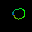

test_alphabet/a expected, 0 found with score 0.996094


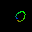

test_alphabet/a expected, 0 found with score 0.996094


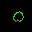

test_alphabet/a expected, 0 found with score 0.996094


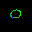

test_alphabet/a expected, 0 found with score 0.996094


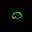

test_alphabet/a expected, 0 found with score 0.996094


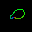

test_alphabet/a expected, 0 found with score 0.996094


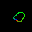

test_alphabet/a expected, 0 found with score 0.996094


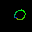

test_alphabet/a expected, 0 found with score 0.996094


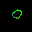

test_alphabet/a expected, 0 found with score 0.996094


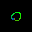

test_alphabet/a expected, 0 found with score 0.996094


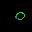

test_alphabet/a expected, 0 found with score 0.996094


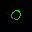

test_alphabet/a expected, 0 found with score 0.996094


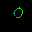

test_alphabet/a expected, 0 found with score 0.996094


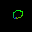

test_alphabet/a expected, 0 found with score 0.996094


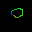

test_alphabet/a expected, 0 found with score 0.996094


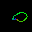

test_alphabet/a expected, 0 found with score 0.996094


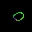

test_alphabet/a expected, 0 found with score 0.996094


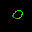

test_alphabet/a expected, 0 found with score 0.996094


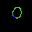

test_alphabet/a expected, 0 found with score 0.996094


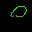

test_alphabet/a expected, 0 found with score 0.996094


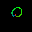

test_alphabet/a expected, 0 found with score 0.996094


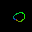

test_alphabet/a expected, 0 found with score 0.996094


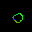

test_alphabet/a expected, 0 found with score 0.996094


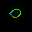

test_alphabet/a expected, 0 found with score 0.996094


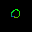

test_alphabet/a expected, 0 found with score 0.996094


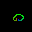

test_alphabet/a expected, 0 found with score 0.996094


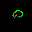

test_alphabet/a expected, 0 found with score 0.996094


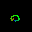

test_alphabet/a expected, 0 found with score 0.996094


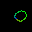

test_alphabet/a expected, 0 found with score 0.996094


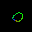

test_alphabet/a expected, 0 found with score 0.996094


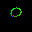

test_alphabet/a expected, 0 found with score 0.996094


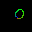

test_alphabet/a expected, 0 found with score 0.996094


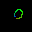

test_alphabet/a expected, 0 found with score 0.996094


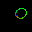

test_alphabet/a expected, 0 found with score 0.996094


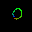

test_alphabet/a expected, 0 found with score 0.996094


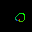

test/b expected, 0 found with score 0.996094


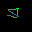

test/b expected, 0 found with score 0.996094


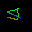

test/b expected, 0 found with score 0.996094


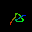

test/b expected, 0 found with score 0.996094


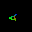

test/b expected, 0 found with score 0.996094


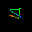

test/b expected, 1 found with score 0.765625


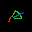

test/b expected, 0 found with score 0.988281


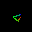

test/b expected, 0 found with score 0.984375


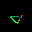

test/b expected, 0 found with score 0.996094


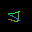

test/b expected, 0 found with score 0.996094


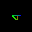

test/b expected, 0 found with score 0.996094


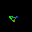

test/b expected, 0 found with score 0.914062


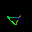

test/b expected, 0 found with score 0.996094


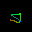

test/b expected, 0 found with score 0.996094


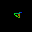

test/b expected, 0 found with score 0.996094


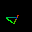

test/b expected, 0 found with score 0.996094


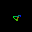

test/b expected, 0 found with score 0.964844


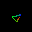

test/b expected, 0 found with score 0.996094


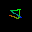

test/b expected, 0 found with score 0.996094


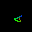

test/b expected, 1 found with score 0.867188


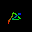

test/b expected, 0 found with score 0.996094


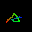

test/b expected, 0 found with score 0.832031


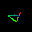

test/b expected, 0 found with score 0.996094


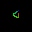

test/b expected, 0 found with score 0.996094


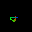

test/b expected, 0 found with score 0.996094


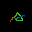

test/b expected, 0 found with score 0.996094


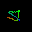

test/b expected, 0 found with score 0.906250


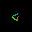

test/b expected, 0 found with score 0.996094


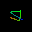

test/b expected, 0 found with score 0.960938


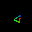

test/b expected, 0 found with score 0.992188


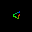

test/b expected, 0 found with score 0.996094


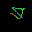

test/b expected, 0 found with score 0.984375


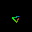

test/b expected, 0 found with score 0.843750


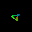

test/b expected, 0 found with score 0.945312


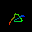

test/b expected, 1 found with score 0.867188


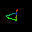

test/b expected, 0 found with score 0.972656


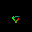

test/b expected, 0 found with score 0.890625


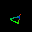

test/b expected, 0 found with score 0.996094


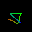

test/b expected, 0 found with score 0.996094


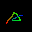

test/b expected, 0 found with score 0.964844


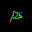

test/b expected, 0 found with score 0.980469


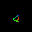

test/b expected, 0 found with score 0.996094


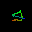

test/b expected, 0 found with score 0.972656


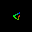

test/b expected, 0 found with score 0.996094


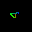

test/b expected, 0 found with score 0.996094


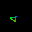

test/b expected, 0 found with score 0.996094


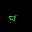

test/b expected, 0 found with score 0.976562


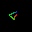

test/a expected, 0 found with score 0.996094


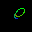

test/a expected, 0 found with score 0.996094


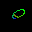

test/a expected, 0 found with score 0.996094


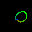

test/a expected, 0 found with score 0.996094


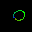

test/a expected, 0 found with score 0.996094


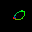

test/a expected, 0 found with score 0.996094


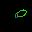

test/a expected, 0 found with score 0.996094


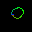

test/a expected, 0 found with score 0.996094


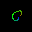

test/a expected, 0 found with score 0.996094


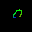

test/a expected, 0 found with score 0.996094


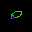

test/a expected, 0 found with score 0.996094


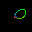

test/a expected, 0 found with score 0.996094


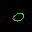

test/a expected, 0 found with score 0.996094


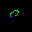

test/a expected, 0 found with score 0.996094


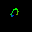

test/a expected, 0 found with score 0.996094


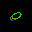

test/a expected, 0 found with score 0.996094


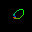

test/a expected, 0 found with score 0.996094


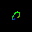

test/a expected, 0 found with score 0.996094


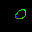

test/a expected, 0 found with score 0.996094


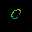

test/a expected, 0 found with score 0.996094


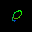

test/a expected, 0 found with score 0.996094


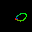

test/a expected, 0 found with score 0.996094


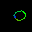

test/a expected, 0 found with score 0.996094


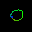

test/a expected, 0 found with score 0.996094


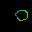

test/a expected, 0 found with score 0.996094


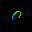

test/a expected, 0 found with score 0.996094


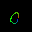

test/a expected, 0 found with score 0.996094


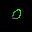

test/a expected, 0 found with score 0.996094


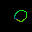

test/a expected, 0 found with score 0.996094


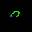

test/a expected, 0 found with score 0.996094


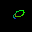

test/a expected, 0 found with score 0.996094


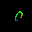

test/a expected, 0 found with score 0.996094


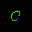

test/a expected, 0 found with score 0.996094


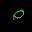

test/a expected, 0 found with score 0.996094


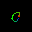

test/a expected, 0 found with score 0.996094


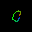

test/a expected, 0 found with score 0.996094


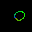

test/a expected, 0 found with score 0.996094


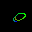

test/a expected, 0 found with score 0.996094


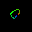

test/a expected, 0 found with score 0.996094


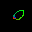

test/a expected, 0 found with score 0.996094


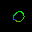

test/a expected, 0 found with score 0.996094


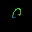

test/a expected, 0 found with score 0.996094


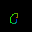

test/a expected, 0 found with score 0.996094


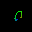

test/a expected, 0 found with score 0.996094


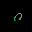

test/a expected, 0 found with score 0.996094


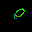

test/a expected, 0 found with score 0.996094


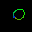

test/a expected, 0 found with score 0.996094


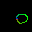

test/a expected, 0 found with score 0.996094


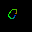

test/a expected, 0 found with score 0.996094


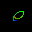

test/a expected, 0 found with score 0.996094


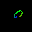

test/a expected, 0 found with score 0.996094


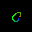

test/a expected, 0 found with score 0.996094


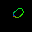

test/a expected, 0 found with score 0.996094


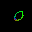

test/a expected, 0 found with score 0.996094


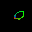

test/a expected, 0 found with score 0.996094


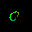

0.0% correct (N=1324, 161 unknown)


In [ ]:
from IPython.display import Image, display

correct_count = 0
wrong_count = 0
discarded_count = 0
for label_dir in glob.glob("test*/*"):
  flag = label_dir.split("/")[0].split("_")[-1]
  if flag == "digit":
    model_tflite = model_tflite_digit
  elif flag == "figure":
    model_tflite = model_tflite_figure
  else:
    model_tflite = model_tflite_alphabet
  label = label_dir.replace("test*/", "")
  for filename in glob.glob(label_dir + "/*.png"):
    index, score = predict_tflite(model_tflite, filename)
    if score < 0.75:
      discarded_count += 1
      continue
    if index == label:
      correct_count += 1
    else:
      wrong_count += 1
      print("%s expected, %d found with score %f" % (label, index, score))
      display(Image(filename=filename))

correct_percentage = (correct_count / (correct_count + wrong_count)) * 100

print("%.1f%% correct (N=%d, %d unknown)" % (correct_percentage, (correct_count + wrong_count), discarded_count))

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_DIGIT_FILENAME} > {TFL_CC_MODEL_DIGIT_FILENAME}
# Update variable names
REPLACE_TEXT_DIGIT = QUANTIZED_TFL_MODEL_DIGIT_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_DIGIT}'/g_magic_wand_model_digit_data/g' {TFL_CC_MODEL_DIGIT_FILENAME}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,373 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,069 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backport

In [ ]:
# Print the C source file
!tail {TFL_CC_MODEL_DIGIT_FILENAME}

  0x4c, 0x00, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00,
  0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff,
  0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09,
  0xf0, 0xff, 0xff, 0xff, 0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x28, 0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_digit_data_len = 31424;


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FIGURE_FILENAME} > {TFL_CC_MODEL_FIGURE_FILENAME}
# Update variable names
REPLACE_TEXT_FIGURE = QUANTIZED_TFL_MODEL_FIGURE_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_FIGURE}'/g_magic_wand_model_figure_data/g' {TFL_CC_MODEL_FIGURE_FILENAME}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
# Print the C source file
!tail {TFL_CC_MODEL_FIGURE_FILENAME}

  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff,
  0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_figure_data_len = 30952;


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_ALPHABET_FILENAME} > {TFL_CC_MODEL_ALPHABET_FILENAME}
# Update variable names
REPLACE_TEXT_ALPHABET = QUANTIZED_TFL_MODEL_ALPHABET_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT_ALPHABET}'/g_magic_wand_model_alphabet_data/g' {TFL_CC_MODEL_ALPHABET_FILENAME}

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [ ]:
# Print the C source file
!tail {TFL_CC_MODEL_ALPHABET_FILENAME}

  0x2c, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xd0, 0xff, 0xff, 0xff, 0x19, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x19, 0xe0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x09, 0xf0, 0xff, 0xff, 0xff,
  0x28, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x28,
  0x0c, 0x00, 0x10, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x00, 0x03
};
unsigned int g_magic_wand_model_alphabet_data_len = 30760;
